# Data preprocessing, GridSearch and Training SpiderNet-6 on Open Data

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression
import re
import gc

import os

#from sklearn.externals import joblib
import joblib

from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all 
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import stratified_split, two_forests, turn_variables_with_values
from Filter_and_Grid_Search import find_meta_params, calculate_vif#, find_meta_params_mem
from Filter_and_Grid_Search import plot_meta_2d, data_preprocessing, find_ouliers_iqr
from Filter_and_Grid_Search import train_model_receive_stats, simple_b_score_risk
from Filter_and_Grid_Search import max_prof_corve, by_month_gini, check_attribute_list_cases

from Filter_and_Grid_Search import to_zip, br_correction, br_stat

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Chinese_data/Datasets/'
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_chinese/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Chinese_data/Datasets/
D:/Share/safanasev/Python-notebook/AF_ML_chinese/


In [24]:
train_data = 'Chinese_train.csv'
#test_data  = 'Chinese_forest.csv'
val_data   = 'Chinese_valid.csv'

In [25]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [27]:
target = 'LABEL'
index_month = 'MONTH'
list_of_vars_for_strat = ['MONTH']
sort_by_var = 'ID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [28]:
COL_DEL

['UNNAMED: 0']

In [29]:
necessary_fields

['LABEL', 'MONTH', 'ID']

In [30]:
n_jobs = 3

In [31]:
path_train_data = PATH_DATA  +  train_data
#path_train_data = PATH_DATA + val_data

## Start of selection

In [32]:
data = pd.read_csv(path_train_data, sep = '&', encoding = 'cp1251'
                   #, index_col = 0
                   , nrows = 10
                  )
data_columns = data.columns

In [33]:
data

,Unnamed: 0,ID,DATE,F1,F2,F3,F4,F5,F6,F7,...,F289,F290,F291,F292,F293,F294,F295,F296,F297,LABEL
0,0,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,20170917,0,1,1,1,100805.0,1,5,...,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0,0
1,1,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,20171029,0,0,0,1,100807.0,1,4,...,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0,0
2,2,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,20171002,1,1,0,1,100805.0,1,5,...,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0,0
3,3,81b481d377dc060f6c3249d086d28b0fb4c3781a72927d...,20171012,0,0,1,1,100802.0,0,6,...,6.0,5.0,5.0,6.0,2.0,1.0,2.0,2.0,2.0,0
4,4,19d100ff146a203f0e558fd60534b8ece650be4ecb4564...,20171027,1,0,0,1,100802.0,0,6,...,314.0,321.0,150.0,302.0,189.0,188.0,189.0,92.0,188.0,0
5,5,49ff13e491c3e4c680cdf39e9b3b85560a4bb80994ac63...,20170926,1,1,1,1,100802.0,0,7,...,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,0
6,6,ee3adc3a1b88a30297f86cf77c0fcd1d5c17653f1a9828...,20171011,1,1,1,0,100804.0,0,2,...,356.0,613.0,82.0,216.0,155.0,156.0,155.0,52.0,116.0,0
7,7,741b5ae5f9f722faca496194ace8bc7920edb8fa1d4477...,20171104,0,0,1,1,100807.0,0,1,...,305.0,321.0,246.0,301.0,132.0,133.0,133.0,100.0,131.0,0
8,8,fa592b16296ad2b2af574bca9d07a48cb2e5fc4e213a34...,20170916,0,1,1,1,100804.0,0,1,...,12.0,14.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,0
9,9,6970c7e69aaec5efba9d6daf130d9ff632bf2f714f5c44...,20171030,1,0,0,1,100803.0,0,5,...,341.0,379.0,129.0,301.0,203.0,202.0,203.0,100.0,202.0,0


In [13]:
path_train_data

'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/antifraud_data_train_with_2014.csv'

In [8]:
for k in data_columns:
    print(k)

Unnamed: 0
ID
DATE
F1
F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
F15
F16
F17
F18
F19
F20
F21
F22
F23
F24
F25
F26
F27
F28
F29
F30
F31
F32
F33
F34
F35
F36
F37
F38
F39
F40
F41
F42
F43
F44
F45
F46
F47
F48
F49
F50
F51
F52
F53
F54
F55
F56
F57
F58
F59
F60
F61
F62
F63
F64
F65
F66
F67
F68
F69
F70
F71
F72
F73
F74
F75
F76
F77
F78
F79
F80
F81
F82
F83
F84
F85
F86
F87
F88
F89
F90
F91
F92
F93
F94
F95
F96
F97
F98
F99
F100
F101
F102
F103
F104
F105
F106
F107
F108
F109
F110
F111
F112
F113
F114
F115
F116
F117
F118
F119
F120
F121
F122
F123
F124
F125
F126
F127
F128
F129
F130
F131
F132
F133
F134
F135
F136
F137
F138
F139
F140
F141
F142
F143
F144
F145
F146
F147
F148
F149
F150
F151
F152
F153
F154
F155
F156
F157
F158
F159
F160
F161
F162
F163
F164
F165
F166
F167
F168
F169
F170
F171
F172
F173
F174
F175
F176
F177
F178
F179
F180
F181
F182
F183
F184
F185
F186
F187
F188
F189
F190
F191
F192
F193
F194
F195
F196
F197
F198
F199
F200
F201
F202
F203
F204
F205
F206
F207
F208
F209
F210
F211
F212
F213
F214
F215
F216
F217
F218

In [34]:
type_cols = {c:'int' for c in necessary_fields}
type_cols

{'LABEL': 'int', 'MONTH': 'int', 'ID': 'int'}

In [27]:
col_out = ['APPPOSID', 'PERIOD_7', 'SUB_CHANNEL', 'COUNT_APP_7', 'DIVISION', 'MONTH_YEAR', 'BAD_FLAG',
          'COUNT_APP_7' , 'COUNT_CONT_7' , 'COUNT_APP_14' , 'COUNT_CONT_14' , 'COUNT_APP_30' , 'COUNT_CONT_30',
           'COUNT_APP_60', 'COUNT_CONT_60']

In [28]:
data_1 = data = pd.read_csv(path_train_data, sep = '&', encoding = 'utf-8', usecols = [c for c in col_out])

In [30]:
data_1.head()

,APPPOSID,PERIOD_7,SUB_CHANNEL,COUNT_APP_7,COUNT_CONT_7,COUNT_APP_14,COUNT_CONT_14,COUNT_APP_30,COUNT_CONT_30,COUNT_APP_60,COUNT_CONT_60,DIVISION,MONTH_YEAR,BAD_FLAG
0,3175,124,LOCALS_OFFLINE,7,3,9,5,12,5,24,11,Приволжский,201710,0
1,3175,125,LOCALS_OFFLINE,2,2,3,2,9,4,19,10,Приволжский,201710,0
2,3175,126,LOCALS_OFFLINE,1,0,3,0,11,3,20,9,Приволжский,201710,0
3,3175,127,LOCALS_OFFLINE,2,0,4,0,10,3,22,11,Приволжский,201709,0
4,3175,128,LOCALS_OFFLINE,2,0,7,2,12,6,22,12,Приволжский,201709,0


In [31]:
data_1.to_csv(PATH + 'train_cut_aug.csv')

In [32]:
PATH

'D:/Share/safanasev/Python-notebook/AF_ML_chinese/'

In [35]:
data = pd.read_csv(path_train_data, sep = '&', encoding = 'utf-8' #'cp1251'
                   #, index_col = 0
                   , usecols = [c for c in data_columns if c.upper() not in COL_DEL]
 #                  , dtype={c:type_cols.get(c.upper(),'float32') for c in data_columns}
                 # , nrows = 100000
                  )
data.columns = [col.upper() for col in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792004 entries, 0 to 792003
Columns: 300 entries, ID to LABEL
dtypes: float64(279), int64(20), object(1)
memory usage: 1.8+ GB


In [36]:
data.head()

,ID,DATE,F1,F2,F3,F4,F5,F6,F7,F8,...,F289,F290,F291,F292,F293,F294,F295,F296,F297,LABEL
0,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,20170917,0,1,1,1,100805.0,1,5,2,...,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0,0
1,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,20171029,0,0,0,1,100807.0,1,4,1,...,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0,0
2,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,20171002,1,1,0,1,100805.0,1,5,1,...,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0,0
3,81b481d377dc060f6c3249d086d28b0fb4c3781a72927d...,20171012,0,0,1,1,100802.0,0,6,2,...,6.0,5.0,5.0,6.0,2.0,1.0,2.0,2.0,2.0,0
4,19d100ff146a203f0e558fd60534b8ece650be4ecb4564...,20171027,1,0,0,1,100802.0,0,6,2,...,314.0,321.0,150.0,302.0,189.0,188.0,189.0,92.0,188.0,0


In [37]:
for c in data.columns:
    if data[c].dtype not in ['float32', 'int64', 'float64']:
        print(c, data[c].dtype)

ID object


In [38]:
columns = [ c for c in data.columns if c not in COL_DEL + necessary_fields]

In [39]:
attribute_list = attributes_list_new(data, columns, [0.01, 0.5, 1, 2, 5, 95, 98, 99, 99.5, 99.99])

[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.800e-01
 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  05.04.2021 11:23:23
Number of finished repetitions: 100 | time:  05.04.2021 11:23:53
Number of finished repetitions: 200 | time:  05.04.2021 11:24:20


In [40]:
#Необходимо проанализировать полученные списки переменных, рекомендовано удалить

#бессмысленные переменные, нет заполненных значений
attribute_list_all_misses = attribute_list[(attribute_list['count_miss'] == data.shape[0])]

#СЛИШКОМ много бинов, подозрение на ID
attribute_list_object_many_distinct =  attribute_list[(attribute_list['count_dist'] >= 150)
                                        & (attribute_list['type_val']!= 'float32')
                                        & (attribute_list['type_val']!= 'float64')] # == 'int')]

#Более 95% пропущено
attribute_list_many_misses = attribute_list[(attribute_list['count_miss'] >= data.shape[0]*0.97)
                                          & (attribute_list['count_miss'] != data.shape[0])]

#Слишком много уникальных значений, подозрение на ID
attribute_list_all_distinct = attribute_list[(attribute_list['count_dist'] >= data.shape[0]*0.95)] 

#Переменная имеет всего одно значение:
attribute_list_сonst =  attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] == 0)]

#Переменная имеет всего одно значение остальные могут быть пустые:
attribute_list_one_value = attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] != 0)]

#Первый персентиль равен 99
attribute_list_1_eq_99 =attribute_list[(attribute_list['1%'] == attribute_list['99%'])]

In [41]:
attribute_list_all_misses

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [42]:
attribute_list_object_many_distinct

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [43]:
attribute_list_all_distinct

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [44]:
attribute_list_many_misses

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [45]:
attribute_list_one_value

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [46]:
attribute_list_1_eq_99

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,1%,2%,5%,val_mediana,95%,98%,99%,99.5%,99.99%,max_val


In [47]:
#Записываем удаленные
def features_for_delete(attribute_list_reason, reason): 
    for_del = pd.DataFrame({'feature': attribute_list_reason['attribute'].to_list()})
    for_del.insert(1, 'reason', reason)
    return for_del

In [48]:
deleted = pd.DataFrame({'feature': [], 'reason': []})

In [49]:
attribute_list_all_misses[['attribute']]

,attribute


In [50]:
deleted = deleted.append(features_for_delete(attribute_list_all_misses,'all_misses'), ignore_index = True)

## Statistics with target variable

In [51]:
#print_log('Start retype target')
target = target.upper()
data[target] = data[target].astype('int')
columns = [c for c in data.columns if c not in COL_DEL and c not in necessary_fields]
len(columns)

298

In [52]:
categorials_from_list = []

In [53]:
#binary = attribute_list.loc[attribute_list['count_dist'] == 2, 'attribute'].to_list()
objects = attribute_list.loc[attribute_list['type_val'] == 'object', 'attribute'].to_list()
all_cats = list(set(categorials_from_list+objects))
categorial_columns = [i for i in data.columns if i in all_cats and i not in COL_DEL + necessary_fields]
str_columns = [i for i in objects if i in data.columns and i not in COL_DEL + necessary_fields]

In [54]:
categorial_columns

[]

In [55]:
data[target].sum()

9699

In [56]:
definition = statistics_with_target(data, columns, target, category_list = categorial_columns, category_target = True)

Number of finished repetitions: 30 | time:  05.04.2021 12:01:40
Number of finished repetitions: 60 | time:  05.04.2021 12:02:05
Number of finished repetitions: 90 | time:  05.04.2021 12:02:33
Number of finished repetitions: 120 | time:  05.04.2021 12:03:00
Number of finished repetitions: 150 | time:  05.04.2021 12:03:25
Number of finished repetitions: 180 | time:  05.04.2021 12:03:51
Number of finished repetitions: 210 | time:  05.04.2021 12:04:16
Number of finished repetitions: 240 | time:  05.04.2021 12:04:41
Number of finished repetitions: 270 | time:  05.04.2021 12:05:06


In [57]:
p_value = 0.1
print(p_value)
definition[definition['stat pvalue'] > p_value].head(20)

0.1


,variable,stat pvalue,corr,corr name
2,F2,0.113181,0.001626,corr
52,F52,0.235714,0.206223,corr
53,F53,0.112536,0.194381,corr
54,F54,0.120216,0.131852,corr
55,F55,0.423454,0.084911,corr
252,F252,0.168187,0.000826,corr
253,F253,0.130946,-0.000577,corr
259,F259,0.137547,0.196091,corr
260,F260,0.240223,0.179149,corr
263,F263,0.369837,0.035641,corr


In [58]:
not_imp = definition[(definition['stat pvalue'] > p_value)]['variable'].to_list()
len(not_imp)

12

In [59]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields:
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(list(set(COL_DEL)))

(288, 13)

In [60]:
definition.to_csv(PATH + 'SandBox/definition.csv')

In [61]:
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'not_imp')

In [62]:
#Записываем оставшиеся
stay5 = pd.DataFrame({'feature': []})
stay5 = stay5.append(columns, ignore_index = True)

## Standardization and imputation of missing values

In [64]:
columns = [i for i in data.columns if i not in COL_DEL + necessary_fields]
len(columns)

286

In [65]:
#print_log('Строим атрибут-лист')
attribute_list_2 = attributes_list_new(data, columns)
#print_log('Атрибут-лист готов')

[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  05.04.2021 12:37:51
Number of finished repetitions: 100 | time:  05.04.2021 12:38:18
Number of finished repetitions: 200 | time:  05.04.2021 12:38:46


In [66]:
data[str_columns] = data[str_columns].fillna(missing_strings)

unique_vals = []

for i in str_columns:
    unique_vals.extend(list(data[i].unique()))
unique_vals = list(set(unique_vals))
unique_vals.sort()    
len(unique_vals)

0

In [67]:
str_columns

[]

In [68]:
le = LabelEncoder()
le.fit(unique_vals)
for i in str_columns:
    print(i)
    data[i] = le.transform(data[i])
    if len(np.where(le.classes_ == missing_strings)[0]) > 0:
        data[i].replace(to_replace = np.where(le.classes_ == missing_strings)[0][0], value = np.nan, inplace = True)

In [69]:
len(np.where(le.classes_ == missing_strings)[0])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


0

In [70]:
data, changes = make_standard(data, columns, target, attribute_list_2, technical_list = necessary_fields, 
                              categorial_list = categorial_columns, label_encoder = le, 
                              string_list = str_columns, mis_value = missing_strings, small_treshold = 10)

In [71]:
changes.to_csv(PATH + 'SandBox/changes.csv', sep = '\t')

In [72]:
new_bins = changes['new variable'].to_list()

In [73]:
columns = [i for i in data.columns if i not in COL_DEL + necessary_fields]
attribute_list_2 = attributes_list_new(data, columns)

[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  05.04.2021 12:40:44
Number of finished repetitions: 100 | time:  05.04.2021 12:41:14
Number of finished repetitions: 200 | time:  05.04.2021 12:41:46
Number of finished repetitions: 300 | time:  05.04.2021 12:42:15
Number of finished repetitions: 400 | time:  05.04.2021 12:42:42
Number of finished repetitions: 500 | time:  05.04.2021 12:43:10


In [74]:
hyper_disbalance = True

In [75]:
if hyper_disbalance == True:
    
    attribute_list_1_eq_99_2 =attribute_list_2[(attribute_list_2['1%'] == attribute_list_2['99%'])]

    check_1_eq_99_2 = check_attribute_list_cases(data, attribute_list_1_eq_99_2, target.upper(), task = task)

    left_vars= check_1_eq_99_2.loc[(check_1_eq_99_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_1_eq_99_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_1_eq_99_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_1_eq_99_to_delete_2 = attribute_list_1_eq_99_2 #[~attribute_list_1_eq_99_2.isin(left_vars)]

In [76]:
if hyper_disbalance== True:
    attribute_list_one_value_2 =  attribute_list_2[attribute_list_2['count_dist'] == 1]

    check_one_value_2 = check_attribute_list_cases(data, attribute_list_one_value_2, target.upper(), task = task)

    left_vars_one_val= check_one_value_2.loc[(check_one_value_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_one_value_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_one_value_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_one_value_for_delete_2 = attribute_list_one_value_2 #[~attribute_list_one_value_2.isin(left_vars_one_val)]

In [77]:
if hyper_disbalance== True:
    deleted = pd.DataFrame({'feature': [], 'reason': []})
    deleted = deleted.append(features_for_delete(attribute_list_1_eq_99_to_delete_2,'1_perc_eq_99_perc_after_bin'), 
                             ignore_index = True)

    deleted = deleted.append(features_for_delete(attribute_list_one_value_for_delete_2,'one_value_after_bin'), 
                             ignore_index = True)

In [78]:
if hyper_disbalance== True:
    for i in attribute_list_1_eq_99_to_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields:
            COL_DEL.append(i)

    for i in attribute_list_one_value_for_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields:
            COL_DEL.append(i)

In [79]:
if hyper_disbalance== True:
    for i in necessary_fields:
        if i in COL_DEL:
            print(i)

In [80]:
attribute_list_2.to_csv(PATH + 'SandBox/attribute_list_var_binned.csv', sep='&')
if hyper_disbalance== True:
    file_name = PATH + 'Selection/excel/6. BL_Разведочная_Статистика_после_Биннинга.xlsx'
    deleted.to_excel(file_name, index = False)

In [81]:
data = data_preprocessing_train(data, target, 
                                technical_values = necessary_fields, 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = False, 
                                median = 'median',
                                high_outlier = None, 
                                low_outlier = None, 
                                cols_outlier = None)

In [82]:
columns = [c for c in data.columns if c not in COL_DEL + necessary_fields]

In [83]:
len(data.columns), len(columns), len(necessary_fields), len(COL_DEL)

(522, 508, 3, 13)

In [84]:
definition_2 = statistics_with_target(data, columns, target, category_list = categorial_columns)

Number of finished repetitions: 30 | time:  05.04.2021 12:44:12
Number of finished repetitions: 60 | time:  05.04.2021 12:44:35
Number of finished repetitions: 90 | time:  05.04.2021 12:45:00
Number of finished repetitions: 120 | time:  05.04.2021 12:45:26
Number of finished repetitions: 150 | time:  05.04.2021 12:45:48
Number of finished repetitions: 180 | time:  05.04.2021 12:46:05
Number of finished repetitions: 210 | time:  05.04.2021 12:46:21
Number of finished repetitions: 240 | time:  05.04.2021 12:46:38
Number of finished repetitions: 270 | time:  05.04.2021 12:46:57
Number of finished repetitions: 300 | time:  05.04.2021 12:47:14
Number of finished repetitions: 330 | time:  05.04.2021 12:47:22
Number of finished repetitions: 360 | time:  05.04.2021 12:47:29
Number of finished repetitions: 390 | time:  05.04.2021 12:47:36
Number of finished repetitions: 420 | time:  05.04.2021 12:47:44
Number of finished repetitions: 450 | time:  05.04.2021 12:47:50
Number of finished repetitio

In [85]:
definition_2[definition_2['stat pvalue'] > 0.1]

,variable,stat pvalue,corr,corr name
41,F42,0.208885,-0.005696,corr
43,F44,0.201056,-0.006505,corr
61,F66,0.108726,-0.010274,corr
99,F104,0.182702,-0.017923,corr
149,F154,0.267218,-0.017149,corr


In [86]:
not_imp = definition_2[definition_2['stat pvalue'] > 0.1]['variable'].to_list()
print(len(not_imp))

5


In [87]:
definition_2.to_csv(PATH + 'SandBox/definition_2.csv')

In [88]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields:
        #print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]        
len(columns), len(COL_DEL) 

(505, 18)

In [89]:
print(necessary_fields)
for i in necessary_fields:
    if i in COL_DEL:
        print(i)

['LABEL', 'MONTH', 'ID']


In [90]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'target_after_bin')

In [91]:
columns = [c for c in data.columns if c not in COL_DEL]
stay7 = pd.DataFrame({'feature': columns})
stay7.head()

,feature
0,ID
1,DATE
2,F1
3,F3
4,F4


In [92]:
file_name = PATH + 'Selection/excel/10. f_target_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [93]:
file_name = PATH + 'Selection/excel/11. f_target_s_aft_bin.xlsx'
stay7.to_excel(file_name, index = False)

## Search correlated features on a binning sample

In [94]:
columns = [c for c in data.columns if c not in COL_DEL + necessary_fields]
len(columns), len(data.columns)

(503, 522)

In [95]:
data.shape

(792004, 522)

In [96]:
categorial_columns1 = [c for c in categorial_columns if c not in COL_DEL and c in data.columns]
len(categorial_columns1)

0

In [97]:
#Проверим, что все категориальные переменные заполнены
data[categorial_columns1].dropna().shape == data[categorial_columns1].shape

True

In [98]:
categorials_data_fin = pd.DataFrame()
categorials_data_fin['feature'] = categorial_columns1
categorials_data_fin.to_csv(PATH + 'SandBox/categories_fin.csv', sep = '&')

In [99]:
correlation_num1, correlation_cat1 = receive_correlations(data[columns], categorial_list = categorial_columns1)

Начало time:  05.04.2021 12:48:11
Корреляционная матрица по числовым переменным посчитана time:  05.04.2021 13:02:43
Корреляционная матрица по категориальным переменным посчитана time:  05.04.2021 13:02:43


In [100]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.80, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.80, light_unstable = None)

Порог = 0.8 Осталось фичей = 0 Коррелир.фичей = 0
Порог = 0.8 Осталось фичей = 129 Коррелир.фичей = 374


In [101]:
result_tab_num1.to_csv(PATH + 'SandBox/result_tab_num_binned.csv', sep = '&')
result_tab_cat1.to_csv(PATH + 'SandBox/result_tab_cat_binned.csv', sep = '&')

In [102]:
non_doubles1 = list(set(non_doubles_cat1 + non_doubles_num1))

In [103]:
pd_non_doubles1 = pd.DataFrame()
pd_non_doubles1['val'] = non_doubles1
pd_non_doubles1.to_csv(PATH + 'SandBox/non_doubles_binned.csv', sep = '&')

In [104]:
file_name = PATH + 'Selection/excel/12. COR_NUM_binned.xlsx'
correlation_num1.to_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT_binned.xlsx'
correlation_cat1.to_excel(file_name)

In [105]:
for i in col_doubles_cat1 + col_doubles_num1:
    if i not in COL_DEL and i not in necessary_fields:
#        print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL) 

(131, 392)

In [106]:
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL)

(131, 392)

In [107]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': col_doubles_cat1 + col_doubles_num1})
deleted.insert(1, 'reason', 'doubles_after_bin')

#Записываем оставшиеся
stay13 = pd.DataFrame({'feature': columns})

In [108]:
file_name = PATH + 'Selection/excel/12. f_double_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [109]:
file_name = PATH + 'Selection/excel/13. f_double_s_aft_bin.xlsx'
stay13.to_excel(file_name, index = False)

In [110]:
cols_true = [x for x in stay13['feature'].to_list() if x not in necessary_fields ]

In [111]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in cols_true:
    #print(i)
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields:
    new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)
#new_features_data_no_vif = new_features_data[~new_features_data['new variable'].isin(vif_del)]
new_features_data_no_vif_no_sys = new_features_data[~new_features_data['new variable'].isin(necessary_fields)]

In [112]:
new_features_data.to_csv(PATH + '/SandBox/selected_features_forest.csv', sep = '\t')
#new_features_data_no_vif.to_csv(PATH + '/SandBox/selected_features_forest_vif.csv', sep = '\t')
new_features_data_no_vif_no_sys.to_csv(PATH + '/SandBox/selected_features_forest_vif_no_sys.csv', sep = '\t')

In [113]:
new_features_data

,new variable,genuine variable,rule,values
0,DATE,DATE,Missing,NaN
1,F1,F1,Missing,NaN
2,F3,F3,Missing,NaN
3,F4,F4,Missing,NaN
4,F5,F5,Missing,NaN
...,...,...,...,...
127,F48_bin,F48,_bin,NaN
128,F166_bin,F166,_bin,NaN
129,LABEL,LABEL,Missing,NaN
130,MONTH,MONTH,Missing,NaN


## Training

In [187]:
new_features_data_no_vif = pd.read_csv(PATH + '/SandBox/selected_features_forest.csv', sep = '\t', index_col=0)
new_features_data_no_vif_no_sys = pd.read_csv(PATH + '/SandBox/selected_features_forest_vif_no_sys.csv', sep = '\t', index_col = 0)
categorials_data_fin = pd.read_csv(PATH + 'SandBox/categories_fin.csv', sep = '\t', index_col=0)
definition_2 = pd.read_csv(PATH + 'SandBox/definition_2.csv', index_col=0)

In [188]:
selected_features = new_features_data_no_vif

In [189]:
cols = selected_features['genuine variable'].drop_duplicates().to_list()

In [190]:
train_data = 'Chinese_train.csv'
#test_data  = 'Chinese_forest.csv'
val_data   = 'Chinese_valid.csv'

In [191]:
# Загружаем только необходимые колонки и в нужном формате
# 'cp1251'
raw_columns = (pd.read_csv(PATH_DATA +  train_data, sep = '&', encoding = 'utf-8', nrows = 0)).columns # исходные имена колонок
#dtype={c:type_cols.get(c.upper(),'float32') for c in raw_columns}                                                  # справочник для исходных колонок
train = pd.read_csv(PATH_DATA  +  train_data, sep = '&', encoding = 'utf-8',  #dtype=dtype, 
                    usecols=[c for c in raw_columns if c.upper() in cols])

val   = pd.read_csv(PATH_DATA +   val_data,   sep = '&', encoding = 'cp1251',  
                    #dtype=dtype, 
                    usecols=[c for c in raw_columns if c.upper() in cols])
train.columns = [col.upper() for col in train.columns]

val.columns   = [col.upper() for col in val.columns]


In [192]:
selected_features.drop(index=130, inplace = True)

In [193]:
train = turn_variables_with_values(train, selected_features)
val  = turn_variables_with_values(val,  selected_features)
#oot   = turn_variables_with_values(oot,   selected_features)

In [194]:
train.shape, val.shape

((792004, 131), (198002, 131))

In [195]:
val['MONTH'] = val['DATE']// 100

In [196]:
X_1, X_2, y_1, y_2 = stratified_split(val, target, ['MONTH'], 'ID', 
                                      size_of_test = 0.5, drop_technical = False, random_state = 241)

In [197]:
X_1 = X_1.join(y_1)
X_2 = X_2.join(y_2)

X_1.drop(['MONTH'], axis = 1)
X_2.drop(['MONTH'], axis = 1)

X_1.to_csv(PATH+'/Data Sets/Chinese_valid_1half_valid.csv', sep = '&', encoding = 'cp1251') 
X_2.to_csv(PATH+'/Data Sets/Chinese_valid_2half_test.csv', sep = '&', encoding = 'cp1251') 

In [198]:
X_1.shape, X_2.shape

((99001, 132), (99001, 132))

In [199]:
y_train = train[target]
y_val = X_1[target]
y_test = X_2[target]

train.drop(target, axis = 1, inplace = True)
X_1.drop(target, axis = 1, inplace = True)
X_2.drop(target, axis = 1, inplace = True)

In [200]:
y_train = y_train.astype('int')
y_test  = y_test.astype('int')
y_val   = y_val.astype('int')

In [201]:
list_of_columns = selected_features['new variable'].to_list()
list_of_columns_no_sys = [c for c in list_of_columns if c not in necessary_fields]

In [202]:
attribute_list_model = attributes_list_new(train, list_of_columns_no_sys, [0.01, 0.5, 1, 2, 5, 95, 97, 
                                                                           98, 99, 99.5, 99.99])

[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.700e-01
 9.800e-01 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  05.04.2021 18:40:23
Number of finished repetitions: 100 | time:  05.04.2021 18:40:43


In [203]:
list_of_categories_sel = attribute_list_model.loc[(attribute_list_model['count_dist'] == 2), 'attribute'].to_list() 

In [204]:
for i in list_of_columns_no_sys:
    if i in categorials_data_fin:
        list_of_categories_sel.append(i)

In [205]:
cols_num = [c for c in list_of_columns_no_sys if c not in list_of_categories_sel]
len(cols_num)

124

In [206]:
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']

In [207]:
attribute_list_model

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,val_mediana,95%,97%,98%,99%,99.5%,99.99%,max_val,right_border,left_border
0,F1,int64,3,0,1.0,396096,792004.0,0.725219,0.651442,0.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
1,F3,int64,3,0,1.0,395822,792004.0,0.698996,0.640019,0.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
2,F4,int64,3,0,1.0,396283,792004.0,0.524804,0.523292,0.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0
3,F5,float64,311,158500,100805.0,147656,633504.0,100653.843403,3975.482690,10000.0,...,100804.0,100806.0,100807.0,100807.0,100807.0,100807.0,150401.0,150406.0,100807.0,100019.0
4,F6,int64,5,0,1.0,377293,792004.0,0.698533,0.753929,0.0,...,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,F296,float64,279,164627,2.0,149392,627377.0,41.209644,45.659537,1.0,...,17.0,118.0,126.0,133.0,155.0,176.0,276.0,280.0,155.0,1.0
124,F5_bin,int32,2,0,1.0,633504,792004.0,0.799875,0.400094,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
125,F36_bin,int32,2,0,0.0,736888,792004.0,0.069591,0.254456,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
126,F48_bin,int32,2,0,1.0,520313,792004.0,0.656958,0.474726,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [208]:
attribute_list_model.to_csv(PATH + '/attribute_list.csv', sep = '\t')

In [209]:
train.columns

Index(['DATE', 'F1', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       ...
       'F276', 'F277', 'F283', 'F288', 'F296', 'F5_bin', 'F36_bin', 'F48_bin',
       'F166_bin', 'ID'],
      dtype='object', length=130)

In [210]:
necessary_fields.append('DATE')

In [211]:
necessary_fields

['LABEL', 'MONTH', 'ID', 'DATE', 'DATE']

In [212]:
from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import data_preprocessing_train

In [213]:
list_of_columns_no_sys = [c for c in list_of_columns if c not in necessary_fields]
cols_outliers = list_of_columns_no_sys.copy()

In [214]:
X_1_2,  preproc_ = data_preprocessing_train(train, y_train, #test, y_test, 
                                                    technical_values = necessary_fields, 
                                                       categorial_list = list_of_categories_sel, drop_technical = True,
                                                       yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', 
                                                       median = 'val_mediana', 
                                                       
                                                       high_outlier = 'right_border', 
                                                       low_outlier = 'left_border', 
                                                    check_percentile = 5,
                                                       cols_outlier = cols_outliers, 
                                                       cut_non_out_9999 = True)

In [215]:
X_2_2 = data_preprocessing_test(X_1, y_val, necessary_fields, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                                attribute_list = attribute_list_model, var_col = 'attribute',
                                median = 'val_mediana',
                                high_outlier = 'right_border',
                                low_outlier = 'left_border', 
                                scale =  preproc_, 
                                #yeo_johnson = None,
                                cols_outlier = cols_outliers)

In [216]:
X_3_2 = data_preprocessing_test(X_2, y_test,  necessary_fields, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                                attribute_list = attribute_list_model, var_col = 'attribute',
                                median = 'val_mediana',
                                high_outlier = 'right_border',
                                low_outlier = 'left_border', 
                                scale =  preproc_, 
                                #yeo_johnson = None,
                                cols_outlier = cols_outliers)

In [164]:
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [165]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [166]:
from keras.utils import np_utils
from tensorflow.keras.models import Model

In [167]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler
#from keras.callbacks import EarlyStopping, Callback

# объявляем класс метрик

class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('train_begin', '| time: ' , tm)
        
    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('epoch_end', '| time: ' , tm)
    
        return

_time = E_time()

In [168]:
import tensorflow as tf

In [169]:
print(tf.__version__)

2.3.0


In [170]:
#если alpha не задано, то не делаем br_correction

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha = 0.1, random_state = 42, 
                 shuffle=True, class_w = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)
        
        
        #print(data_tmp_b.shape[0], data_tmp.shape[0], data_tmp_b_all.shape[0])
        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col] 
            
        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]
            #print(data_tmp_b.shape[0], data_tmp.shape[0],  data_tmp_b.shape[0]/(data_tmp.shape[0] - X_tmp.shape[0]), np.mean(y)) 
            
            
            
        else:
            if data_tmp_b.shape[0] > 0:
                k=(self.alpha*self.batch_size/data_tmp_b.shape[0] -1 )/(1-self.alpha)
                for i in range(0,int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

    #         print('Добавим дробное число строк')    
            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))
    #         print(k_fraction, n_samples)

            ix = np.random.RandomState(self.random_state).choice(data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)


            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]   
        #print(sum(self.dataset.loc[batch][self.y_col])/len(index), np.mean(y))
        
        if self.num_classes > 1:
            y = np_utils.to_categorical( y, self.num_classes)
            
        ####for tf 2.3.0, [np.array(X)], np.array(y)

        #return [np.array(X).reshape(X.shape[0], X.shape[1], 1)], np.array(y)
        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [217]:
x_col = X_1_2.columns
y_col = target

In [218]:
len(x_col)

128

In [219]:
train_for = pd.concat( [X_1_2, y_train] , axis = 1 )

In [220]:
sum(y_train)/y_train.count()

0.012246150271968324

In [221]:
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.1 ) #было 0,05
#validation_generator = DataGenerator(valid_for, x_col, y_col, batch_size=valid_for.shape[0], alpha = None, class_w = None)

In [222]:
from tensorflow.keras.callbacks import EarlyStopping

In [223]:
#X_2_2 = data_preprocessing_test(X_1, y_val
Y_test_2 = np_utils.to_categorical( y_val, 2) # преобразовываем в 2 класса 

In [224]:
X_1_2.shape,  X_2_2.shape, Y_test_2.shape

((792004, 128), (99001, 128), (99001, 2))

In [225]:
X_3_2.shape

(99001, 128)

## Loading data

In [411]:
#train_for = pd.concat( [X_1_2, y_train] , axis = 1 )
test_for = pd.concat( [X_3_2, y_test] , axis = 1 )
valid_for =  pd.concat( [X_2_2, y_val] , axis = 1 )

In [412]:
PATH + 'train_128_prep.csv'

'D:/Share/safanasev/Python-notebook/AF_ML_chinese/train_128_prep.csv'

In [413]:
train_for.to_csv(PATH + 'china_train_128_prep.csv')
test_for.to_csv(PATH + 'china_test_128_prep.csv')
valid_for.to_csv(PATH + 'china_val_128_prep.csv')

In [193]:
train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [194]:
y_train = train_for[target]
y_test = valid_for[target]
y_val = test_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [195]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

In [26]:
Y_test_2 = np_utils.to_categorical( y_test, 2) # преобразовываем в 2 класса 

In [27]:
x_col

Index(['COUNT_CONT_30', 'W_TEST_AGE_6_60D', 'W_TEST_AGE_ALL5_7D',
       'B_TEST_PASP_D_3_7D', 'B_TEST_PASP_D_3_14D', 'B_TEST_PASP_D_3_30D',
       'B_TEST_PASP_D_3_60D', 'B_TEST_PASP_D_10_7D', 'B_TEST_PASP_D_10_30D',
       'B_TEST_PASP_D_ALL5_30D',
       ...
       'DIVISION_Южный', 'AVG_FUND_TT_7_bin', 'AVG_FUND_TT_14_bin',
       'STD_SUM_TT_14_bin', 'AVG_FUND_TT_30_bin', 'STD_SUM_TT_30_bin',
       'STD_SUM_TT_60_bin', 'RULE_1_TRE3_SHARE_7_bin',
       'RULE_1_TRE3_SHARE_14_bin', 'COUNT_CONT_FIO7_7_bin'],
      dtype='object', length=163)

# *

In [226]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 29

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# ***

## SpiderNet-6

In [277]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [366]:
#добавлена l2(weight_decay) в batchnorm и conv
#weight_decay_conv = 1E-4
l2_conv = None #l2(1E-5)
l2_batch_gamma = l2(1E-5) #None#
l2_batch_betta =l2(1E-5)  #None #
_bias = True #False True лучше чем false

l2_dense = l2(1E-5)

from keras.regularizers import l2

n_features = X_1_2.shape[1]
#x = Input(shape=( time_steps, n_features))
x = Input(shape=(  n_features, 1))
#k = 1
n_pool = 2
n_kernel = 5
n_filters = 5
n_strides = 1
classes = 2
hidden = 64 #256
drop_out = 0.25

drop_out_conv = 0.001
drop_out_rate = 4


n = 0
#padding_pool = 'same'
padding_pool = 'valid'

# первый блок
y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
shortcut1_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)## поправить
shortcut1_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_2)##
shortcut1_4 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_3)##
shortcut1_5 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_4)


#y = MaxPooling1D(pool_size = n_pool, padding='same')(y)
#y = add([shortcut1_1, y])
#y = Concatenate(axis=-1)([shortcut1_1, y])

# второй spider-block
y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
          use_bias=_bias, kernel_regularizer=l2_conv)(y) 
y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)

y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
shortcut2_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##
shortcut2_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut2_2)##
shortcut2_4 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut2_3)


y= Concatenate(axis=-1)([shortcut1_2, y])
n = n+1
#y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
#print(n, drop_out_conv*(n**drop_out_rate))

# третий spider-block
y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
          use_bias=_bias, kernel_regularizer=l2_conv)(y) 
y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)

y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
shortcut3_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##
shortcut3_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut3_2)##

y= Concatenate(axis=-1)([shortcut2_2, shortcut1_3, y])
n = n+1
#y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
#print(n, drop_out_conv*(n**drop_out_rate))


# четвертый spider-block
y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
          use_bias=_bias, kernel_regularizer=l2_conv)(y) 
y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)

y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
shortcut4_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##

y= Concatenate(axis=-1)([shortcut3_2, shortcut2_3, shortcut1_4, y])
n = n+1
y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
print(n, drop_out_conv*(n**drop_out_rate))

# пятый spider-block
y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
          use_bias=_bias, kernel_regularizer=l2_conv)(y) 
y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)

y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
y= Concatenate(axis=-1)([shortcut4_2, shortcut3_3, shortcut2_4, shortcut1_5, y])
n = n+1
y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
print(n, drop_out_conv*(n**drop_out_rate))

# шестой spider-block
y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
          use_bias=_bias, kernel_regularizer=l2_conv)(y) 
y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
y = ReLU()(y)

#z = BatchNormalization()(y)
#z = ReLU()(z)   
z = GlobalAveragePooling1D()(y)
#z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
z = Dense(hidden, activation='relu', kernel_regularizer = l2_dense)(z)
z = Dropout(drop_out)(z)
z = Dense(hidden, activation='relu', kernel_regularizer = l2_dense)(z)
z = Dropout(drop_out)(z)
predictions = Dense(classes, activation='softmax')(z)

#model = Sequential()
model_15 = Model(inputs=x, outputs=predictions)

3 0.081
4 0.256


In [387]:
y = Input(shape=(  n_features))

predictions_z = Dense(classes, activation='softmax')(y)
model_test = Model(inputs=y, outputs=predictions_z)

model_test.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model_test.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 258       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


In [399]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])[:, 1]
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2: #and val_targ.shape[1] != 1:
            val_targ = val_targ[:,1]

        _val_aps = metrics.average_precision_score(val_targ, val_predict)
        #_val_recall = metrics.recall_score(val_targ, val_predict)
        _val_a = metrics.roc_auc_score(val_targ, val_predict)

        logs['val_aps'] = _val_aps
        logs['val_a'] = _val_a
        print(" — val_aps:  %f — val_g: %f" % (_val_aps, _val_a))
        return

In [342]:
#model_15 = Model(inputs=x, outputs=predictions)
model_15.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model_15.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 128, 5)       30          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 5)       20          conv1d_12[0][0]                  
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 128, 5)       0           batch_normalization_12[0][0]     
_______________________________________________________________________________________

In [232]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

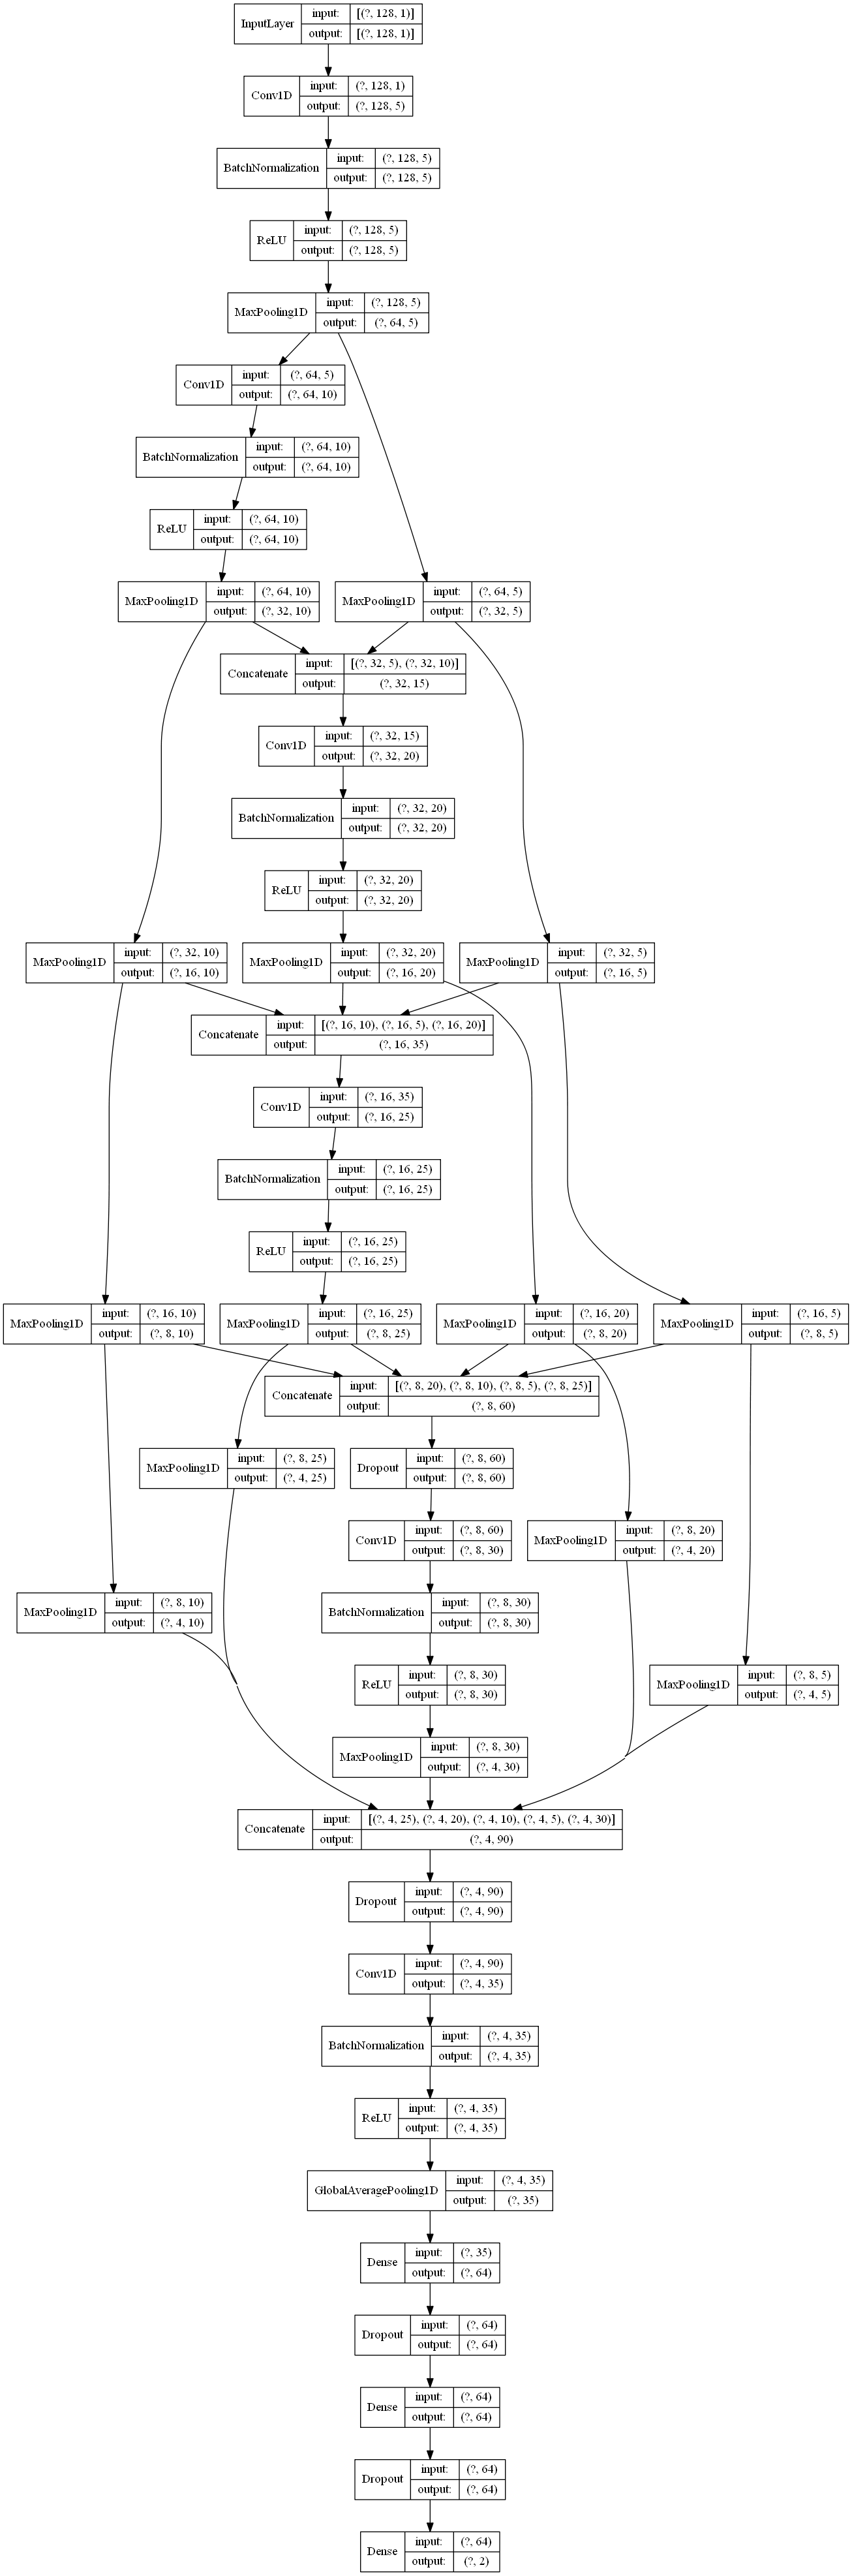

In [233]:
tf.keras.utils.plot_model(model_15, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [234]:
#training_aug = DataGenerator(aug_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05 )
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.1 )

In [235]:
#learning_rate=0.005
initial_learning_rate = 0.005

def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 20.0
    
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [398]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 1
class_weighting = {0:0.1 , 1:1} #{0:0.00163 , 1:1}

with tf.device('/GPU:0'):
    history_XX = model_test.fit_generator(generator=training_generator, #model_15
                    validation_data= (X_2_2, Y_test_2) ,
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)
                                       , LearningRateScheduler(lr_step_decay, verbose=1),
                                               Metrics(valid_data=(X_2_2, Y_test_2))])

train_begin | time:  08.04.2021 21:30:43

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0006784900758454762.
epoch_end | time:  08.04.2021 21:32:56
(99001,) 0.15125771 (99001,)
 — val_aps:  0.324674 — val_g: 0.954548
1547/1547 - 136s - loss: 0.0420 - accuracy: 0.8843 - auc_9: 0.9620 - precision_9: 0.8843 - recall_9: 0.8843 - val_loss: 0.2690 - val_accuracy: 0.8774 - val_auc_9: 0.9594 - val_precision_9: 0.8774 - val_recall_9: 0.8774


In [270]:
history_XX.history

{'loss': [0.011833959259092808],
 'accuracy': [0.9791308045387268],
 'auc_9': [0.9963716864585876],
 'precision_9': [0.9791308045387268],
 'recall_9': [0.9791308045387268],
 'val_loss': [0.05490526184439659],
 'val_accuracy': [0.9808082580566406],
 'val_auc_9': [0.9977059960365295],
 'val_precision_9': [0.9808082580566406],
 'val_recall_9': [0.9808082580566406],
 'lr': [0.005],
 'val_aps': [0.2739938481669502],
 'val_recall': [0.7475247524752475]}

In [237]:
test = pd.DataFrame.from_dict(model_15.get_config()['layers'])
c  = str(sum(test['class_name']=='Conv1D')) + 'china_'
dd = str(200000 + datetime.now().month*100 + datetime.now().day) + '_' + str(datetime.now().hour)

In [238]:
res_model_cnn3 = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
model_15.save('model_spider_' + c + '_' + dd +'.h5')
res_model_cnn3.to_csv('model_spider_' + c + '_' + dd + '.csv')

In [243]:
predict_class_val = model_15.predict(X_2_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.5126761010668028, 0.9744922657447923, 0.9489845314895846)

In [244]:
predict_class_val = model_15.predict(X_3_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.4946545926330232, 0.9742563291179324, 0.9485126582358647)

In [185]:
#val (0.5126761010668028, 0.9744922657447923, 0.9489845314895846)
#test (0.4946545926330232, 0.9742563291179324, 0.9485126582358647)


In [246]:
import urllib
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

## SpiderNet-6

In [249]:
def spider_model(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut1_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)## поправить
    shortcut1_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_2)##
    shortcut1_4 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_3)##
    shortcut1_5 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut1_4)

    # второй spider-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut2_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##
    shortcut2_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut2_2)##
    shortcut2_4 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut2_3)


    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий spider-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut3_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##
    shortcut3_3 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(shortcut3_2)##

    y= Concatenate(axis=-1)([shortcut2_2, shortcut1_3, y])
    n = n+1
    # четвертый spider-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut4_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##

    y= Concatenate(axis=-1)([shortcut3_2, shortcut2_3, shortcut1_4, y])
    n = n+1
    y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
    print(n, drop_out_conv*(n**drop_out_rate))

    # пятый spider-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    y= Concatenate(axis=-1)([shortcut4_2, shortcut3_3, shortcut2_4, shortcut1_5, y])
    n = n+1
    y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
    print(n, drop_out_conv*(n**drop_out_rate))

    # шестой spider-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [251]:
scorer = metrics.make_scorer(metrics.average_precision_score)

model_15.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[scorer])

## GridSearch by Optuna

In [339]:
BATCHSIZE = 512
CLASSES = 2
EPOCHS = 100
inp_shape = X_2_2.shape[1] # open data



def create_model(trial):

    # Hyperparameters to be tuned by Optuna.
    reg = trial.suggest_float("reg", 1e-4, 1e-1, log=True)
    reg_dense = trial.suggest_float("reg_dense", 1e-4, 1e-1, log=True)
    n_kernel = trial.suggest_int("n_kernel", 3, 7)
    n_filters = trial.suggest_categorical("n_filters", [5, 7, 10, 15, 20])
    hidden = trial.suggest_categorical("hidden", [30, 50, 64])
    drop_out_conv = trial.suggest_float("drop_out_conv", 0.0001, 0.002)
    gl_pool_max = trial.suggest_categorical("gl_pool_max", [True, False])
    drop_out = trial.suggest_float("drop_out", 0.1, 0.4)
    
    lr_rate = trial.suggest_float("learning_rate", 0.0001, 0.01)

    # Compose neural network with one hidden layer.
    model = spider_model(reg = reg , reg_dense = reg_dense,n_features = inp_shape, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = hidden , drop_out = drop_out, drop_out_conv = drop_out_conv, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = gl_pool_max)
    
        # Compile model.
    model.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate), 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    
    return model

In [337]:
VERBOSE = 2


def objective(trial):
    # Clear clutter from previous TensorFlow graphs.
    tf.keras.backend.clear_session()

    # Metrics to be monitored by Optuna.
    #if tf.__version__ >= "2":
       # monitor = "val_accuracy"
    #else:
        #monitor = "val_acc"
        
    monitor = 'val_aps'

    # Create tf.keras model instance.
    model = create_model(trial)

    # Create dataset instance.
    #ds_train = train_dataset()
    #ds_eval = eval_dataset()

    # Create callbacks for early stopping and pruning.
    callbacks = [Metrics(valid_data=(X_2_2, Y_test_2)), 
        tf.keras.callbacks.EarlyStopping(patience=5),
        TFKerasPruningCallback(trial, monitor),
    ]

    # Train model.
    history = model.fit_generator(generator=training_generator, 
                    validation_data= (X_2_2, Y_test_2) ,
                                  verbose=VERBOSE , 
        epochs=EPOCHS,
        callbacks=callbacks
    )

    return history.history[monitor][-1]


def show_result_old(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [338]:
def show_result(study):

    pruned_trials = [i for i in study.trials if str(i.state) == 'TrialState.PRUNED']
    complete_trials = [i for i in study.trials if str(i.state) == 'TrialState.COMPLETE']

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [400]:
#study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=2))

#Prune if the trial’s best intermediate result is worse than median of intermediate results 
#of previous trials at the same step
#n_startup_trials - кол-во испытаний, на которых рассчитывается медиана
#n_warmup_steps - минимальное кол-во эпох, которые отрабатывает каждая модель
#interval_steps - шаг, с которым осуществляется проверка, если параметр не передается, то модель обучится до конца
#по дефолту - n_startup_trials=5, n_warmup_steps=0, interval_steps=1

#study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=2))

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))

#n_trials – The number of trials. If this argument is set to None, there is no limitation on the number of trials. 
#If timeout is also set to None, the study continues to create trials until it receives a termination signal 
#such as Ctrl+C or SIGTERM.
study.optimize(objective, n_trials=30)
show_result(study)

3 0.0530081489416249
4 0.16753192751920956
Epoch 1/100
 — val_aps:  0.362962 — val_g: 0.919532
1547/1547 - 396s - loss: 0.5514 - accuracy: 0.9629 - auc: 0.9924 - precision: 0.9629 - recall: 0.9629 - val_loss: 0.0970 - val_accuracy: 0.9881 - val_auc: 0.9964 - val_precision: 0.9881 - val_recall: 0.9881
Epoch 2/100
 — val_aps:  0.379587 — val_g: 0.935538
1547/1547 - 406s - loss: 0.1188 - accuracy: 0.9762 - auc: 0.9955 - precision: 0.9762 - recall: 0.9762 - val_loss: 0.1059 - val_accuracy: 0.9880 - val_auc: 0.9929 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 3/100
 — val_aps:  0.435237 — val_g: 0.948974
1547/1547 - 402s - loss: 0.1088 - accuracy: 0.9782 - auc: 0.9957 - precision: 0.9782 - recall: 0.9782 - val_loss: 0.0844 - val_accuracy: 0.9812 - val_auc: 0.9980 - val_precision: 0.9812 - val_recall: 0.9812
Epoch 4/100
 — val_aps:  0.401014 — val_g: 0.947560
1547/1547 - 394s - loss: 0.1017 - accuracy: 0.9796 - auc: 0.9960 - precision: 0.9796 - recall: 0.9796 - val_loss: 0.0726 - val_a

[I 2021-04-08 23:02:00,158] Trial 0 finished with value: 0.4433415172811192 and parameters: {'reg': 0.04790962113790054, 'reg_dense': 0.001488751572853646, 'n_kernel': 5, 'n_filters': 5, 'hidden': 30, 'drop_out_conv': 0.0006544215918719123, 'gl_pool_max': True, 'drop_out': 0.32220977565764036, 'learning_rate': 0.004572797796743471}. Best is trial 0 with value: 0.4433415172811192.


3 0.07996400992120135
4 0.25272575975095735
Epoch 1/100
 — val_aps:  0.414456 — val_g: 0.948756
1547/1547 - 394s - loss: 0.1306 - accuracy: 0.9705 - auc: 0.9952 - precision: 0.9705 - recall: 0.9705 - val_loss: 0.2016 - val_accuracy: 0.9216 - val_auc: 0.9802 - val_precision: 0.9216 - val_recall: 0.9216
Epoch 2/100
 — val_aps:  0.417373 — val_g: 0.950726
1547/1547 - 398s - loss: 0.0755 - accuracy: 0.9804 - auc: 0.9967 - precision: 0.9804 - recall: 0.9804 - val_loss: 0.0580 - val_accuracy: 0.9888 - val_auc: 0.9966 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 3/100
 — val_aps:  0.443757 — val_g: 0.957138
1547/1547 - 404s - loss: 0.0688 - accuracy: 0.9827 - auc: 0.9971 - precision: 0.9827 - recall: 0.9827 - val_loss: 0.0655 - val_accuracy: 0.9819 - val_auc: 0.9980 - val_precision: 0.9819 - val_recall: 0.9819
Epoch 4/100
 — val_aps:  0.427789 — val_g: 0.961514
1547/1547 - 401s - loss: 0.0667 - accuracy: 0.9834 - auc: 0.9972 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.0507 - val_

[I 2021-04-09 00:35:12,042] Trial 1 finished with value: 0.46954189232438975 and parameters: {'reg': 0.004788016416014292, 'reg_dense': 0.0003053790571139943, 'n_kernel': 5, 'n_filters': 20, 'hidden': 64, 'drop_out_conv': 0.0009872099990271771, 'gl_pool_max': False, 'drop_out': 0.11704790077003134, 'learning_rate': 0.006941062808246899}. Best is trial 1 with value: 0.46954189232438975.


3 0.09330463626703091
4 0.2948887269674063
Epoch 1/100
 — val_aps:  0.412251 — val_g: 0.955915
1547/1547 - 387s - loss: 0.1312 - accuracy: 0.9654 - auc: 0.9938 - precision: 0.9654 - recall: 0.9654 - val_loss: 0.2040 - val_accuracy: 0.9058 - val_auc: 0.9816 - val_precision: 0.9058 - val_recall: 0.9058
Epoch 2/100
 — val_aps:  0.444625 — val_g: 0.963959
1547/1547 - 392s - loss: 0.0762 - accuracy: 0.9800 - auc: 0.9964 - precision: 0.9800 - recall: 0.9800 - val_loss: 0.0712 - val_accuracy: 0.9758 - val_auc: 0.9977 - val_precision: 0.9758 - val_recall: 0.9758
Epoch 3/100
 — val_aps:  0.454142 — val_g: 0.963060
1547/1547 - 394s - loss: 0.0687 - accuracy: 0.9824 - auc: 0.9968 - precision: 0.9824 - recall: 0.9824 - val_loss: 0.0595 - val_accuracy: 0.9834 - val_auc: 0.9979 - val_precision: 0.9834 - val_recall: 0.9834
Epoch 4/100
 — val_aps:  0.471350 — val_g: 0.964924
1547/1547 - 386s - loss: 0.0648 - accuracy: 0.9839 - auc: 0.9970 - precision: 0.9839 - recall: 0.9839 - val_loss: 0.0469 - val_a

[I 2021-04-09 01:40:29,167] Trial 2 finished with value: 0.4737278784366771 and parameters: {'reg': 0.0016463919203173565, 'reg_dense': 0.0007197644138041479, 'n_kernel': 7, 'n_filters': 7, 'hidden': 30, 'drop_out_conv': 0.001151909089716431, 'gl_pool_max': False, 'drop_out': 0.3353033225732434, 'learning_rate': 0.0056305796200511}. Best is trial 2 with value: 0.4737278784366771.


3 0.0497634616828448
4 0.15727711346676876
Epoch 1/100
 — val_aps:  0.455176 — val_g: 0.965619
1547/1547 - 398s - loss: 0.0991 - accuracy: 0.9719 - auc: 0.9955 - precision: 0.9719 - recall: 0.9719 - val_loss: 0.1038 - val_accuracy: 0.9640 - val_auc: 0.9955 - val_precision: 0.9640 - val_recall: 0.9640
Epoch 2/100
 — val_aps:  0.470168 — val_g: 0.964050
1547/1547 - 402s - loss: 0.0638 - accuracy: 0.9823 - auc: 0.9973 - precision: 0.9823 - recall: 0.9823 - val_loss: 0.0586 - val_accuracy: 0.9819 - val_auc: 0.9980 - val_precision: 0.9819 - val_recall: 0.9819
Epoch 3/100
 — val_aps:  0.440219 — val_g: 0.966218
1547/1547 - 403s - loss: 0.0575 - accuracy: 0.9846 - auc: 0.9976 - precision: 0.9846 - recall: 0.9846 - val_loss: 0.0812 - val_accuracy: 0.9734 - val_auc: 0.9965 - val_precision: 0.9734 - val_recall: 0.9734
Epoch 4/100
 — val_aps:  0.453362 — val_g: 0.969140
1547/1547 - 395s - loss: 0.0541 - accuracy: 0.9858 - auc: 0.9979 - precision: 0.9858 - recall: 0.9858 - val_loss: 0.0444 - val_a

[I 2021-04-09 02:47:12,396] Trial 3 finished with value: 0.46874829039313315 and parameters: {'reg': 0.000852831606077958, 'reg_dense': 0.001453750778223593, 'n_kernel': 3, 'n_filters': 5, 'hidden': 50, 'drop_out_conv': 0.0006143637244795655, 'gl_pool_max': True, 'drop_out': 0.16426483619130944, 'learning_rate': 0.008012938051423736}. Best is trial 2 with value: 0.4737278784366771.


3 0.07925319435596208
4 0.25047923154476903
Epoch 1/100
 — val_aps:  0.362668 — val_g: 0.944874
1547/1547 - 395s - loss: 1.1569 - accuracy: 0.9656 - auc: 0.9941 - precision: 0.9656 - recall: 0.9656 - val_loss: 0.1558 - val_accuracy: 0.9761 - val_auc: 0.9959 - val_precision: 0.9761 - val_recall: 0.9761
Epoch 2/100
 — val_aps:  0.368749 — val_g: 0.947488
1547/1547 - 401s - loss: 0.1271 - accuracy: 0.9769 - auc: 0.9961 - precision: 0.9769 - recall: 0.9769 - val_loss: 0.0940 - val_accuracy: 0.9876 - val_auc: 0.9984 - val_precision: 0.9876 - val_recall: 0.9876
Epoch 3/100
 — val_aps:  0.390571 — val_g: 0.944087
1547/1547 - 404s - loss: 0.1108 - accuracy: 0.9797 - auc: 0.9966 - precision: 0.9797 - recall: 0.9797 - val_loss: 0.0841 - val_accuracy: 0.9886 - val_auc: 0.9982 - val_precision: 0.9886 - val_recall: 0.9886
Epoch 4/100
 — val_aps:  0.394466 — val_g: 0.946470
1547/1547 - 394s - loss: 0.1021 - accuracy: 0.9811 - auc: 0.9967 - precision: 0.9811 - recall: 0.9811 - val_loss: 0.0791 - val_

[I 2021-04-09 05:08:10,031] Trial 4 finished with value: 0.42483771285144556 and parameters: {'reg': 0.08381532348375066, 'reg_dense': 0.010954988126584124, 'n_kernel': 7, 'n_filters': 5, 'hidden': 50, 'drop_out_conv': 0.000978434498221754, 'gl_pool_max': True, 'drop_out': 0.16623032889175984, 'learning_rate': 0.0031074550949767112}. Best is trial 2 with value: 0.4737278784366771.


3 0.04763675858897434
4 0.15055568146638804
Epoch 1/100
 — val_aps:  0.400714 — val_g: 0.942949
1547/1547 - 406s - loss: 0.1398 - accuracy: 0.9677 - auc: 0.9945 - precision: 0.9677 - recall: 0.9677 - val_loss: 0.1218 - val_accuracy: 0.9563 - val_auc: 0.9943 - val_precision: 0.9563 - val_recall: 0.9563
Epoch 2/100
 — val_aps:  0.427913 — val_g: 0.955699
1547/1547 - 405s - loss: 0.0804 - accuracy: 0.9792 - auc: 0.9965 - precision: 0.9792 - recall: 0.9792 - val_loss: 0.0601 - val_accuracy: 0.9851 - val_auc: 0.9981 - val_precision: 0.9851 - val_recall: 0.9851
Epoch 3/100
 — val_aps:  0.412191 — val_g: 0.956232
1547/1547 - 400s - loss: 0.0740 - accuracy: 0.9818 - auc: 0.9969 - precision: 0.9818 - recall: 0.9818 - val_loss: 0.0564 - val_accuracy: 0.9888 - val_auc: 0.9970 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 4/100
 — val_aps:  0.433149 — val_g: 0.958616
1547/1547 - 400s - loss: 0.0714 - accuracy: 0.9827 - auc: 0.9970 - precision: 0.9827 - recall: 0.9827 - val_loss: 0.0615 - val_

[I 2021-04-09 06:15:13,899] Trial 5 pruned. Trial was pruned at epoch 9.


3 0.03692037096581645
4 0.1166866045339384
Epoch 1/100
 — val_aps:  0.440377 — val_g: 0.962156
1547/1547 - 407s - loss: 0.1140 - accuracy: 0.9732 - auc: 0.9956 - precision: 0.9732 - recall: 0.9732 - val_loss: 0.0546 - val_accuracy: 0.9853 - val_auc: 0.9982 - val_precision: 0.9853 - val_recall: 0.9853
Epoch 2/100
 — val_aps:  0.444412 — val_g: 0.962592
1547/1547 - 394s - loss: 0.0626 - accuracy: 0.9835 - auc: 0.9972 - precision: 0.9835 - recall: 0.9835 - val_loss: 0.0801 - val_accuracy: 0.9736 - val_auc: 0.9968 - val_precision: 0.9736 - val_recall: 0.9736
Epoch 3/100
 — val_aps:  0.392918 — val_g: 0.961959
1547/1547 - 403s - loss: 0.0558 - accuracy: 0.9855 - auc: 0.9976 - precision: 0.9855 - recall: 0.9855 - val_loss: 0.0693 - val_accuracy: 0.9763 - val_auc: 0.9973 - val_precision: 0.9763 - val_recall: 0.9763
Epoch 4/100
 — val_aps:  0.450510 — val_g: 0.967516
1547/1547 - 405s - loss: 0.0519 - accuracy: 0.9866 - auc: 0.9978 - precision: 0.9866 - recall: 0.9866 - val_loss: 0.0436 - val_a

[I 2021-04-09 08:22:03,673] Trial 6 finished with value: 0.4473265316306286 and parameters: {'reg': 0.0012980561085074093, 'reg_dense': 0.0808516268515792, 'n_kernel': 4, 'n_filters': 5, 'hidden': 50, 'drop_out_conv': 0.0004558070489606969, 'gl_pool_max': True, 'drop_out': 0.24708559746409808, 'learning_rate': 0.00380844790500926}. Best is trial 2 with value: 0.4737278784366771.


3 0.12359001648078535
4 0.3906054841861858
Epoch 1/100
 — val_aps:  0.418858 — val_g: 0.961771
1547/1547 - 399s - loss: 0.1036 - accuracy: 0.9695 - auc: 0.9947 - precision: 0.9695 - recall: 0.9695 - val_loss: 0.0537 - val_accuracy: 0.9853 - val_auc: 0.9980 - val_precision: 0.9853 - val_recall: 0.9853
Epoch 2/100
 — val_aps:  0.442562 — val_g: 0.965128
1547/1547 - 387s - loss: 0.0701 - accuracy: 0.9808 - auc: 0.9967 - precision: 0.9808 - recall: 0.9808 - val_loss: 0.0566 - val_accuracy: 0.9828 - val_auc: 0.9981 - val_precision: 0.9828 - val_recall: 0.9828
Epoch 3/100
 — val_aps:  0.453537 — val_g: 0.965856
1547/1547 - 397s - loss: 0.0634 - accuracy: 0.9833 - auc: 0.9971 - precision: 0.9833 - recall: 0.9833 - val_loss: 0.0439 - val_accuracy: 0.9885 - val_auc: 0.9985 - val_precision: 0.9885 - val_recall: 0.9885
Epoch 4/100
 — val_aps:  0.428872 — val_g: 0.962724
1547/1547 - 397s - loss: 0.0609 - accuracy: 0.9841 - auc: 0.9972 - precision: 0.9841 - recall: 0.9841 - val_loss: 0.0562 - val_a

[I 2021-04-09 09:48:42,252] Trial 7 finished with value: 0.48176652139197446 and parameters: {'reg': 0.000478109401975365, 'reg_dense': 0.008311940396624909, 'n_kernel': 7, 'n_filters': 15, 'hidden': 50, 'drop_out_conv': 0.0015258026726022882, 'gl_pool_max': False, 'drop_out': 0.35220530008422524, 'learning_rate': 0.00805063630839906}. Best is trial 7 with value: 0.48176652139197446.


3 0.1199561204928479
4 0.3791205783477662
Epoch 1/100
 — val_aps:  0.448992 — val_g: 0.963415
1547/1547 - 431s - loss: 0.1057 - accuracy: 0.9685 - auc: 0.9944 - precision: 0.9685 - recall: 0.9685 - val_loss: 0.0461 - val_accuracy: 0.9877 - val_auc: 0.9980 - val_precision: 0.9877 - val_recall: 0.9877
Epoch 2/100
 — val_aps:  0.397708 — val_g: 0.958781
1547/1547 - 421s - loss: 0.0668 - accuracy: 0.9821 - auc: 0.9968 - precision: 0.9821 - recall: 0.9821 - val_loss: 0.0942 - val_accuracy: 0.9687 - val_auc: 0.9954 - val_precision: 0.9687 - val_recall: 0.9687
Epoch 3/100
 — val_aps:  0.430408 — val_g: 0.963069
1547/1547 - 448s - loss: 0.0604 - accuracy: 0.9840 - auc: 0.9971 - precision: 0.9840 - recall: 0.9840 - val_loss: 0.0622 - val_accuracy: 0.9805 - val_auc: 0.9975 - val_precision: 0.9805 - val_recall: 0.9805
Epoch 4/100
 — val_aps:  0.466740 — val_g: 0.966889
1547/1547 - 444s - loss: 0.0558 - accuracy: 0.9854 - auc: 0.9974 - precision: 0.9854 - recall: 0.9854 - val_loss: 0.0439 - val_ac

[I 2021-04-09 11:12:24,186] Trial 8 finished with value: 0.4655678296342914 and parameters: {'reg': 0.00022398100085646388, 'reg_dense': 0.0460133619779865, 'n_kernel': 3, 'n_filters': 20, 'hidden': 30, 'drop_out_conv': 0.0014809397591709617, 'gl_pool_max': False, 'drop_out': 0.3856414007142478, 'learning_rate': 0.004997150088106958}. Best is trial 7 with value: 0.48176652139197446.


3 0.016809725272152742
4 0.0531270329589025
Epoch 1/100
 — val_aps:  0.394313 — val_g: 0.951222
1547/1547 - 458s - loss: 0.1944 - accuracy: 0.9706 - auc: 0.9949 - precision: 0.9706 - recall: 0.9706 - val_loss: 0.0714 - val_accuracy: 0.9828 - val_auc: 0.9981 - val_precision: 0.9828 - val_recall: 0.9828
Epoch 2/100
 — val_aps:  0.423407 — val_g: 0.953131
1547/1547 - 465s - loss: 0.0833 - accuracy: 0.9807 - auc: 0.9965 - precision: 0.9807 - recall: 0.9807 - val_loss: 0.1207 - val_accuracy: 0.9610 - val_auc: 0.9946 - val_precision: 0.9610 - val_recall: 0.9610
Epoch 3/100
 — val_aps:  0.395116 — val_g: 0.955676
1547/1547 - 475s - loss: 0.0760 - accuracy: 0.9828 - auc: 0.9969 - precision: 0.9828 - recall: 0.9828 - val_loss: 0.1280 - val_accuracy: 0.9529 - val_auc: 0.9936 - val_precision: 0.9529 - val_recall: 0.9529
Epoch 4/100
 — val_aps:  0.426683 — val_g: 0.944913
1547/1547 - 462s - loss: 0.0737 - accuracy: 0.9834 - auc: 0.9970 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.0715 - val_

[I 2021-04-09 12:01:24,196] Trial 9 pruned. Trial was pruned at epoch 5.


3 0.15773695332619114
4 0.49852666730253004
Epoch 1/100
 — val_aps:  0.396650 — val_g: 0.955375
1547/1547 - 529s - loss: 0.1557 - accuracy: 0.9488 - auc: 0.9886 - precision: 0.9488 - recall: 0.9488 - val_loss: 0.0683 - val_accuracy: 0.9806 - val_auc: 0.9979 - val_precision: 0.9806 - val_recall: 0.9806
Epoch 2/100
 — val_aps:  0.413066 — val_g: 0.958057
1547/1547 - 535s - loss: 0.0902 - accuracy: 0.9756 - auc: 0.9958 - precision: 0.9756 - recall: 0.9756 - val_loss: 0.0766 - val_accuracy: 0.9759 - val_auc: 0.9975 - val_precision: 0.9759 - val_recall: 0.9759
Epoch 3/100
 — val_aps:  0.422556 — val_g: 0.957834
1547/1547 - 508s - loss: 0.0751 - accuracy: 0.9805 - auc: 0.9966 - precision: 0.9805 - recall: 0.9805 - val_loss: 0.0509 - val_accuracy: 0.9873 - val_auc: 0.9982 - val_precision: 0.9873 - val_recall: 0.9873
Epoch 4/100
 — val_aps:  0.434728 — val_g: 0.959344
1547/1547 - 459s - loss: 0.0672 - accuracy: 0.9827 - auc: 0.9971 - precision: 0.9827 - recall: 0.9827 - val_loss: 0.0492 - val_

[I 2021-04-09 12:50:44,084] Trial 10 pruned. Trial was pruned at epoch 5.


3 0.12092438322848517
4 0.38218076674681734
Epoch 1/100
 — val_aps:  0.398027 — val_g: 0.955213
1547/1547 - 459s - loss: 0.1084 - accuracy: 0.9680 - auc: 0.9944 - precision: 0.9680 - recall: 0.9680 - val_loss: 0.0519 - val_accuracy: 0.9855 - val_auc: 0.9978 - val_precision: 0.9855 - val_recall: 0.9855
Epoch 2/100
 — val_aps:  0.432273 — val_g: 0.961523
1547/1547 - 445s - loss: 0.0711 - accuracy: 0.9807 - auc: 0.9966 - precision: 0.9807 - recall: 0.9807 - val_loss: 0.0490 - val_accuracy: 0.9881 - val_auc: 0.9977 - val_precision: 0.9881 - val_recall: 0.9881
Epoch 3/100
 — val_aps:  0.445426 — val_g: 0.961312
1547/1547 - 457s - loss: 0.0649 - accuracy: 0.9832 - auc: 0.9969 - precision: 0.9832 - recall: 0.9832 - val_loss: 0.0735 - val_accuracy: 0.9735 - val_auc: 0.9971 - val_precision: 0.9735 - val_recall: 0.9735
Epoch 4/100
 — val_aps:  0.414551 — val_g: 0.963122
1547/1547 - 463s - loss: 0.0619 - accuracy: 0.9842 - auc: 0.9971 - precision: 0.9842 - recall: 0.9842 - val_loss: 0.0567 - val_

[I 2021-04-09 14:09:29,467] Trial 11 finished with value: 0.4010258137273957 and parameters: {'reg': 0.0005754839202287065, 'reg_dense': 0.005796086609844303, 'n_kernel': 7, 'n_filters': 15, 'hidden': 30, 'drop_out_conv': 0.0014928936201047552, 'gl_pool_max': False, 'drop_out': 0.33834264930953983, 'learning_rate': 0.007014494347815013}. Best is trial 7 with value: 0.48176652139197446.


3 0.11735822865200186
4 0.3709099572211417
Epoch 1/100
 — val_aps:  0.429157 — val_g: 0.960816
1547/1547 - 502s - loss: 0.1094 - accuracy: 0.9662 - auc: 0.9940 - precision: 0.9662 - recall: 0.9662 - val_loss: 0.0497 - val_accuracy: 0.9858 - val_auc: 0.9980 - val_precision: 0.9858 - val_recall: 0.9858
Epoch 2/100
 — val_aps:  0.417365 — val_g: 0.960674
1547/1547 - 473s - loss: 0.0721 - accuracy: 0.9802 - auc: 0.9966 - precision: 0.9802 - recall: 0.9802 - val_loss: 0.0598 - val_accuracy: 0.9856 - val_auc: 0.9970 - val_precision: 0.9856 - val_recall: 0.9856
Epoch 3/100
 — val_aps:  0.428342 — val_g: 0.961325
1547/1547 - 485s - loss: 0.0660 - accuracy: 0.9826 - auc: 0.9969 - precision: 0.9826 - recall: 0.9826 - val_loss: 0.1058 - val_accuracy: 0.9643 - val_auc: 0.9957 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 4/100
 — val_aps:  0.480433 — val_g: 0.967870
1547/1547 - 489s - loss: 0.0637 - accuracy: 0.9834 - auc: 0.9970 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.0454 - val_a

[I 2021-04-09 16:21:08,163] Trial 12 finished with value: 0.43213779216521364 and parameters: {'reg': 0.000321762320325618, 'reg_dense': 0.0002994196441900459, 'n_kernel': 7, 'n_filters': 7, 'hidden': 30, 'drop_out_conv': 0.0014488670203950847, 'gl_pool_max': False, 'drop_out': 0.34136292126595325, 'learning_rate': 0.008592579830395266}. Best is trial 7 with value: 0.48176652139197446.


3 0.14983338856041176
4 0.47354749964772114
Epoch 1/100
 — val_aps:  0.431046 — val_g: 0.960009
1547/1547 - 531s - loss: 0.1227 - accuracy: 0.9653 - auc: 0.9936 - precision: 0.9653 - recall: 0.9653 - val_loss: 0.0842 - val_accuracy: 0.9732 - val_auc: 0.9970 - val_precision: 0.9732 - val_recall: 0.9732
Epoch 2/100
 — val_aps:  0.417776 — val_g: 0.957616
1547/1547 - 527s - loss: 0.0861 - accuracy: 0.9765 - auc: 0.9958 - precision: 0.9765 - recall: 0.9765 - val_loss: 0.0731 - val_accuracy: 0.9781 - val_auc: 0.9975 - val_precision: 0.9781 - val_recall: 0.9781
Epoch 3/100
 — val_aps:  0.415143 — val_g: 0.958356
1547/1547 - 539s - loss: 0.0783 - accuracy: 0.9797 - auc: 0.9963 - precision: 0.9797 - recall: 0.9797 - val_loss: 0.0642 - val_accuracy: 0.9804 - val_auc: 0.9980 - val_precision: 0.9804 - val_recall: 0.9804
Epoch 4/100
 — val_aps:  0.436899 — val_g: 0.956056
1547/1547 - 546s - loss: 0.0746 - accuracy: 0.9810 - auc: 0.9966 - precision: 0.9810 - recall: 0.9810 - val_loss: 0.0788 - val_

[I 2021-04-09 17:15:03,380] Trial 13 pruned. Trial was pruned at epoch 5.


3 0.10201638356736678
4 0.32242215053389994
Epoch 1/100
 — val_aps:  0.431637 — val_g: 0.956564
1547/1547 - 478s - loss: 0.0953 - accuracy: 0.9703 - auc: 0.9949 - precision: 0.9703 - recall: 0.9703 - val_loss: 0.0505 - val_accuracy: 0.9838 - val_auc: 0.9981 - val_precision: 0.9838 - val_recall: 0.9838
Epoch 2/100
 — val_aps:  0.429301 — val_g: 0.960527
1547/1547 - 475s - loss: 0.0633 - accuracy: 0.9821 - auc: 0.9971 - precision: 0.9821 - recall: 0.9821 - val_loss: 0.0576 - val_accuracy: 0.9823 - val_auc: 0.9979 - val_precision: 0.9823 - val_recall: 0.9823
Epoch 3/100
 — val_aps:  0.429535 — val_g: 0.962813
1547/1547 - 459s - loss: 0.0568 - accuracy: 0.9843 - auc: 0.9974 - precision: 0.9843 - recall: 0.9843 - val_loss: 0.0438 - val_accuracy: 0.9867 - val_auc: 0.9983 - val_precision: 0.9867 - val_recall: 0.9867
Epoch 4/100
 — val_aps:  0.415568 — val_g: 0.962682
1547/1547 - 464s - loss: 0.0531 - accuracy: 0.9854 - auc: 0.9976 - precision: 0.9854 - recall: 0.9854 - val_loss: 0.0483 - val_

[I 2021-04-09 18:03:32,945] Trial 14 pruned. Trial was pruned at epoch 5.


3 0.14057899953878705
4 0.4442990602707344
Epoch 1/100
 — val_aps:  0.386579 — val_g: 0.954056
1547/1547 - 552s - loss: 0.4852 - accuracy: 0.9644 - auc: 0.9936 - precision: 0.9644 - recall: 0.9644 - val_loss: 0.0704 - val_accuracy: 0.9882 - val_auc: 0.9987 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 2/100
 — val_aps:  0.417612 — val_g: 0.953048
1547/1547 - 492s - loss: 0.0928 - accuracy: 0.9796 - auc: 0.9963 - precision: 0.9796 - recall: 0.9796 - val_loss: 0.0705 - val_accuracy: 0.9888 - val_auc: 0.9966 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 3/100
 — val_aps:  0.421699 — val_g: 0.955987
1547/1547 - 476s - loss: 0.0822 - accuracy: 0.9821 - auc: 0.9967 - precision: 0.9821 - recall: 0.9821 - val_loss: 0.0629 - val_accuracy: 0.9889 - val_auc: 0.9970 - val_precision: 0.9889 - val_recall: 0.9889
Epoch 4/100
 — val_aps:  0.388636 — val_g: 0.951096
1547/1547 - 476s - loss: 0.0757 - accuracy: 0.9837 - auc: 0.9969 - precision: 0.9837 - recall: 0.9837 - val_loss: 0.0669 - val_a

[I 2021-04-09 18:53:29,072] Trial 15 pruned. Trial was pruned at epoch 5.


3 0.09593859106923179
4 0.30321332486078195
Epoch 1/100
 — val_aps:  0.411215 — val_g: 0.959757
1547/1547 - 471s - loss: 0.1033 - accuracy: 0.9692 - auc: 0.9947 - precision: 0.9692 - recall: 0.9692 - val_loss: 0.0507 - val_accuracy: 0.9865 - val_auc: 0.9980 - val_precision: 0.9865 - val_recall: 0.9865
Epoch 2/100
 — val_aps:  0.414428 — val_g: 0.958661
1547/1547 - 458s - loss: 0.0674 - accuracy: 0.9815 - auc: 0.9968 - precision: 0.9815 - recall: 0.9815 - val_loss: 0.0555 - val_accuracy: 0.9848 - val_auc: 0.9979 - val_precision: 0.9848 - val_recall: 0.9848
Epoch 3/100
 — val_aps:  0.423853 — val_g: 0.964518
1547/1547 - 478s - loss: 0.0604 - accuracy: 0.9842 - auc: 0.9972 - precision: 0.9842 - recall: 0.9842 - val_loss: 0.0490 - val_accuracy: 0.9846 - val_auc: 0.9983 - val_precision: 0.9846 - val_recall: 0.9846
Epoch 4/100
 — val_aps:  0.405601 — val_g: 0.963725
1547/1547 - 467s - loss: 0.0582 - accuracy: 0.9847 - auc: 0.9973 - precision: 0.9847 - recall: 0.9847 - val_loss: 0.0486 - val_

[I 2021-04-09 20:36:10,925] Trial 16 pruned. Trial was pruned at epoch 12.


3 0.131322590936922
4 0.4150442380228646
Epoch 1/100
 — val_aps:  0.396270 — val_g: 0.956487
1547/1547 - 485s - loss: 0.1234 - accuracy: 0.9687 - auc: 0.9945 - precision: 0.9687 - recall: 0.9687 - val_loss: 0.0603 - val_accuracy: 0.9827 - val_auc: 0.9981 - val_precision: 0.9827 - val_recall: 0.9827
Epoch 2/100
 — val_aps:  0.435115 — val_g: 0.960257
1547/1547 - 464s - loss: 0.0760 - accuracy: 0.9794 - auc: 0.9965 - precision: 0.9794 - recall: 0.9794 - val_loss: 0.0625 - val_accuracy: 0.9829 - val_auc: 0.9980 - val_precision: 0.9829 - val_recall: 0.9829
Epoch 3/100
 — val_aps:  0.428174 — val_g: 0.960185
1547/1547 - 468s - loss: 0.0687 - accuracy: 0.9822 - auc: 0.9969 - precision: 0.9822 - recall: 0.9822 - val_loss: 0.0587 - val_accuracy: 0.9834 - val_auc: 0.9982 - val_precision: 0.9834 - val_recall: 0.9834
Epoch 4/100
 — val_aps:  0.426424 — val_g: 0.955680
1547/1547 - 441s - loss: 0.0662 - accuracy: 0.9831 - auc: 0.9971 - precision: 0.9831 - recall: 0.9831 - val_loss: 0.0595 - val_acc

[I 2021-04-09 21:21:47,754] Trial 17 pruned. Trial was pruned at epoch 5.


3 0.07019775753382868
4 0.2218595793661746
Epoch 1/100
 — val_aps:  0.413880 — val_g: 0.959160
1547/1547 - 419s - loss: 0.0969 - accuracy: 0.9700 - auc: 0.9950 - precision: 0.9700 - recall: 0.9700 - val_loss: 0.0646 - val_accuracy: 0.9800 - val_auc: 0.9977 - val_precision: 0.9800 - val_recall: 0.9800
Epoch 2/100
 — val_aps:  0.437272 — val_g: 0.963336
1547/1547 - 400s - loss: 0.0637 - accuracy: 0.9828 - auc: 0.9970 - precision: 0.9828 - recall: 0.9828 - val_loss: 0.0535 - val_accuracy: 0.9840 - val_auc: 0.9978 - val_precision: 0.9840 - val_recall: 0.9840
Epoch 3/100
 — val_aps:  0.448001 — val_g: 0.966828
1547/1547 - 412s - loss: 0.0588 - accuracy: 0.9848 - auc: 0.9973 - precision: 0.9848 - recall: 0.9848 - val_loss: 0.0770 - val_accuracy: 0.9783 - val_auc: 0.9966 - val_precision: 0.9783 - val_recall: 0.9783
Epoch 4/100
 — val_aps:  0.413234 — val_g: 0.965175
1547/1547 - 403s - loss: 0.0556 - accuracy: 0.9857 - auc: 0.9975 - precision: 0.9857 - recall: 0.9857 - val_loss: 0.0497 - val_a

[I 2021-04-09 22:49:33,157] Trial 18 pruned. Trial was pruned at epoch 12.


3 0.09957041838596756
4 0.3146916926766382
Epoch 1/100
 — val_aps:  0.435518 — val_g: 0.959204
1547/1547 - 402s - loss: 0.1317 - accuracy: 0.9674 - auc: 0.9941 - precision: 0.9674 - recall: 0.9674 - val_loss: 0.0547 - val_accuracy: 0.9888 - val_auc: 0.9973 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 2/100
 — val_aps:  0.438646 — val_g: 0.964447
1547/1547 - 406s - loss: 0.0702 - accuracy: 0.9822 - auc: 0.9967 - precision: 0.9822 - recall: 0.9822 - val_loss: 0.0538 - val_accuracy: 0.9853 - val_auc: 0.9981 - val_precision: 0.9853 - val_recall: 0.9853
Epoch 3/100
 — val_aps:  0.454113 — val_g: 0.966484
1547/1547 - 397s - loss: 0.0614 - accuracy: 0.9846 - auc: 0.9971 - precision: 0.9846 - recall: 0.9846 - val_loss: 0.0440 - val_accuracy: 0.9887 - val_auc: 0.9981 - val_precision: 0.9887 - val_recall: 0.9887
Epoch 4/100
 — val_aps:  0.460424 — val_g: 0.965618
1547/1547 - 400s - loss: 0.0569 - accuracy: 0.9856 - auc: 0.9974 - precision: 0.9856 - recall: 0.9856 - val_loss: 0.0453 - val_a

[I 2021-04-10 00:16:47,835] Trial 19 finished with value: 0.479162431256781 and parameters: {'reg': 0.0008821837365501469, 'reg_dense': 0.002888049962245456, 'n_kernel': 4, 'n_filters': 7, 'hidden': 30, 'drop_out_conv': 0.001229264424518118, 'gl_pool_max': False, 'drop_out': 0.36623271653489725, 'learning_rate': 0.002900019681507893}. Best is trial 7 with value: 0.48176652139197446.


3 0.10921478144592388
4 0.34517264259452485
Epoch 1/100
 — val_aps:  0.403986 — val_g: 0.957147
1547/1547 - 400s - loss: 0.1411 - accuracy: 0.9651 - auc: 0.9939 - precision: 0.9651 - recall: 0.9651 - val_loss: 0.0559 - val_accuracy: 0.9884 - val_auc: 0.9979 - val_precision: 0.9884 - val_recall: 0.9884
Epoch 2/100
 — val_aps:  0.418189 — val_g: 0.959612
1547/1547 - 401s - loss: 0.0714 - accuracy: 0.9820 - auc: 0.9969 - precision: 0.9820 - recall: 0.9820 - val_loss: 0.0598 - val_accuracy: 0.9825 - val_auc: 0.9981 - val_precision: 0.9825 - val_recall: 0.9825
Epoch 3/100
 — val_aps:  0.424948 — val_g: 0.962067
1547/1547 - 398s - loss: 0.0612 - accuracy: 0.9844 - auc: 0.9973 - precision: 0.9844 - recall: 0.9844 - val_loss: 0.0504 - val_accuracy: 0.9868 - val_auc: 0.9980 - val_precision: 0.9868 - val_recall: 0.9868
Epoch 4/100
 — val_aps:  0.377731 — val_g: 0.960417
1547/1547 - 407s - loss: 0.0557 - accuracy: 0.9859 - auc: 0.9975 - precision: 0.9859 - recall: 0.9859 - val_loss: 0.0506 - val_

[I 2021-04-10 00:57:00,364] Trial 20 pruned. Trial was pruned at epoch 5.


3 0.09355392516428093
4 0.2956766029883447
Epoch 1/100
 — val_aps:  0.421417 — val_g: 0.954131
1547/1547 - 404s - loss: 0.1652 - accuracy: 0.9678 - auc: 0.9940 - precision: 0.9678 - recall: 0.9678 - val_loss: 0.0833 - val_accuracy: 0.9744 - val_auc: 0.9971 - val_precision: 0.9744 - val_recall: 0.9744
Epoch 2/100
 — val_aps:  0.414119 — val_g: 0.956693
1547/1547 - 403s - loss: 0.0756 - accuracy: 0.9814 - auc: 0.9964 - precision: 0.9814 - recall: 0.9814 - val_loss: 0.1023 - val_accuracy: 0.9645 - val_auc: 0.9960 - val_precision: 0.9645 - val_recall: 0.9645
Epoch 3/100
 — val_aps:  0.400785 — val_g: 0.957540
1547/1547 - 401s - loss: 0.0680 - accuracy: 0.9839 - auc: 0.9968 - precision: 0.9839 - recall: 0.9839 - val_loss: 0.0579 - val_accuracy: 0.9835 - val_auc: 0.9981 - val_precision: 0.9835 - val_recall: 0.9835
Epoch 4/100
 — val_aps:  0.424024 — val_g: 0.961828
1547/1547 - 403s - loss: 0.0639 - accuracy: 0.9850 - auc: 0.9971 - precision: 0.9850 - recall: 0.9850 - val_loss: 0.0779 - val_a

[I 2021-04-10 01:37:12,898] Trial 21 pruned. Trial was pruned at epoch 5.


3 0.08829611638241176
4 0.2790593307888569
Epoch 1/100
 — val_aps:  0.407119 — val_g: 0.957544
1547/1547 - 400s - loss: 0.1303 - accuracy: 0.9655 - auc: 0.9937 - precision: 0.9655 - recall: 0.9655 - val_loss: 0.0955 - val_accuracy: 0.9683 - val_auc: 0.9964 - val_precision: 0.9683 - val_recall: 0.9683
Epoch 2/100
 — val_aps:  0.440043 — val_g: 0.963277
1547/1547 - 395s - loss: 0.0709 - accuracy: 0.9818 - auc: 0.9967 - precision: 0.9818 - recall: 0.9818 - val_loss: 0.0477 - val_accuracy: 0.9886 - val_auc: 0.9981 - val_precision: 0.9886 - val_recall: 0.9886
Epoch 3/100
 — val_aps:  0.427585 — val_g: 0.961048
1547/1547 - 402s - loss: 0.0646 - accuracy: 0.9835 - auc: 0.9970 - precision: 0.9835 - recall: 0.9835 - val_loss: 0.0593 - val_accuracy: 0.9809 - val_auc: 0.9980 - val_precision: 0.9809 - val_recall: 0.9809
Epoch 4/100
 — val_aps:  0.411677 — val_g: 0.963572
1547/1547 - 398s - loss: 0.0600 - accuracy: 0.9851 - auc: 0.9972 - precision: 0.9851 - recall: 0.9851 - val_loss: 0.0665 - val_a

[I 2021-04-10 02:17:16,944] Trial 22 pruned. Trial was pruned at epoch 5.


3 0.1301535475715512
4 0.41134948368292723
Epoch 1/100
 — val_aps:  0.412416 — val_g: 0.955618
1547/1547 - 403s - loss: 0.1232 - accuracy: 0.9658 - auc: 0.9939 - precision: 0.9658 - recall: 0.9658 - val_loss: 0.0651 - val_accuracy: 0.9789 - val_auc: 0.9978 - val_precision: 0.9789 - val_recall: 0.9789
Epoch 2/100
 — val_aps:  0.443183 — val_g: 0.962368
1547/1547 - 393s - loss: 0.0696 - accuracy: 0.9821 - auc: 0.9967 - precision: 0.9821 - recall: 0.9821 - val_loss: 0.0456 - val_accuracy: 0.9882 - val_auc: 0.9982 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 3/100
 — val_aps:  0.430912 — val_g: 0.962654
1547/1547 - 398s - loss: 0.0627 - accuracy: 0.9838 - auc: 0.9970 - precision: 0.9838 - recall: 0.9838 - val_loss: 0.0459 - val_accuracy: 0.9864 - val_auc: 0.9985 - val_precision: 0.9864 - val_recall: 0.9864
Epoch 4/100
 — val_aps:  0.435859 — val_g: 0.960243
1547/1547 - 390s - loss: 0.0583 - accuracy: 0.9850 - auc: 0.9972 - precision: 0.9850 - recall: 0.9850 - val_loss: 0.0460 - val_a

[I 2021-04-10 02:56:56,206] Trial 23 pruned. Trial was pruned at epoch 5.


3 0.06820942555737042
4 0.21557546842823244
Epoch 1/100
 — val_aps:  0.407431 — val_g: 0.958186
1547/1547 - 398s - loss: 0.2325 - accuracy: 0.9585 - auc: 0.9920 - precision: 0.9585 - recall: 0.9585 - val_loss: 0.0874 - val_accuracy: 0.9875 - val_auc: 0.9982 - val_precision: 0.9875 - val_recall: 0.9875
Epoch 2/100
 — val_aps:  0.433329 — val_g: 0.962968
1547/1547 - 390s - loss: 0.0974 - accuracy: 0.9802 - auc: 0.9966 - precision: 0.9802 - recall: 0.9802 - val_loss: 0.0742 - val_accuracy: 0.9824 - val_auc: 0.9981 - val_precision: 0.9824 - val_recall: 0.9824
Epoch 3/100
 — val_aps:  0.444654 — val_g: 0.964827
1547/1547 - 403s - loss: 0.0754 - accuracy: 0.9836 - auc: 0.9970 - precision: 0.9836 - recall: 0.9836 - val_loss: 0.0598 - val_accuracy: 0.9854 - val_auc: 0.9983 - val_precision: 0.9854 - val_recall: 0.9854
Epoch 4/100
 — val_aps:  0.442903 — val_g: 0.964986
1547/1547 - 397s - loss: 0.0655 - accuracy: 0.9855 - auc: 0.9973 - precision: 0.9855 - recall: 0.9855 - val_loss: 0.0514 - val_

[I 2021-04-10 03:36:50,228] Trial 24 pruned. Trial was pruned at epoch 5.


3 0.10112859669778446
4 0.3196163056127509
Epoch 1/100
 — val_aps:  0.454848 — val_g: 0.962873
1547/1547 - 400s - loss: 0.0998 - accuracy: 0.9698 - auc: 0.9947 - precision: 0.9698 - recall: 0.9698 - val_loss: 0.0440 - val_accuracy: 0.9892 - val_auc: 0.9980 - val_precision: 0.9892 - val_recall: 0.9892
Epoch 2/100
 — val_aps:  0.446157 — val_g: 0.964932
1547/1547 - 390s - loss: 0.0669 - accuracy: 0.9815 - auc: 0.9968 - precision: 0.9815 - recall: 0.9815 - val_loss: 0.0481 - val_accuracy: 0.9853 - val_auc: 0.9983 - val_precision: 0.9853 - val_recall: 0.9853
Epoch 3/100
 — val_aps:  0.451286 — val_g: 0.966346
1547/1547 - 396s - loss: 0.0594 - accuracy: 0.9840 - auc: 0.9972 - precision: 0.9840 - recall: 0.9840 - val_loss: 0.0426 - val_accuracy: 0.9876 - val_auc: 0.9984 - val_precision: 0.9876 - val_recall: 0.9876
Epoch 4/100
 — val_aps:  0.482575 — val_g: 0.966170
1547/1547 - 393s - loss: 0.0558 - accuracy: 0.9852 - auc: 0.9974 - precision: 0.9852 - recall: 0.9852 - val_loss: 0.0388 - val_a

[I 2021-04-10 04:36:12,881] Trial 25 finished with value: 0.42055877924430196 and parameters: {'reg': 0.00017512619790721788, 'reg_dense': 0.0031152004776860104, 'n_kernel': 7, 'n_filters': 20, 'hidden': 30, 'drop_out_conv': 0.0012485011937998082, 'gl_pool_max': False, 'drop_out': 0.3678578877708847, 'learning_rate': 0.006061220878567747}. Best is trial 7 with value: 0.48176652139197446.


3 0.11088831280169995
4 0.35046182811401466
Epoch 1/100
 — val_aps:  0.401573 — val_g: 0.954091
1547/1547 - 395s - loss: 0.1911 - accuracy: 0.9655 - auc: 0.9936 - precision: 0.9655 - recall: 0.9655 - val_loss: 0.0564 - val_accuracy: 0.9871 - val_auc: 0.9982 - val_precision: 0.9871 - val_recall: 0.9871
Epoch 2/100
 — val_aps:  0.386820 — val_g: 0.956719
1547/1547 - 399s - loss: 0.0753 - accuracy: 0.9813 - auc: 0.9965 - precision: 0.9813 - recall: 0.9813 - val_loss: 0.0525 - val_accuracy: 0.9876 - val_auc: 0.9979 - val_precision: 0.9876 - val_recall: 0.9876
Epoch 3/100
 — val_aps:  0.403764 — val_g: 0.953820
1547/1547 - 403s - loss: 0.0677 - accuracy: 0.9835 - auc: 0.9969 - precision: 0.9835 - recall: 0.9835 - val_loss: 0.0549 - val_accuracy: 0.9887 - val_auc: 0.9969 - val_precision: 0.9887 - val_recall: 0.9887
Epoch 4/100
 — val_aps:  0.419241 — val_g: 0.960548
1547/1547 - 390s - loss: 0.0623 - accuracy: 0.9851 - auc: 0.9971 - precision: 0.9851 - recall: 0.9851 - val_loss: 0.0499 - val_

[I 2021-04-10 05:16:08,570] Trial 26 pruned. Trial was pruned at epoch 5.


3 0.14523568754862418
4 0.45901649398083694
Epoch 1/100
 — val_aps:  0.418310 — val_g: 0.956045
1547/1547 - 402s - loss: 0.1156 - accuracy: 0.9683 - auc: 0.9944 - precision: 0.9683 - recall: 0.9683 - val_loss: 0.0808 - val_accuracy: 0.9720 - val_auc: 0.9970 - val_precision: 0.9720 - val_recall: 0.9720
Epoch 2/100
 — val_aps:  0.433395 — val_g: 0.960214
1547/1547 - 392s - loss: 0.0688 - accuracy: 0.9812 - auc: 0.9967 - precision: 0.9812 - recall: 0.9812 - val_loss: 0.0480 - val_accuracy: 0.9882 - val_auc: 0.9976 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 3/100
 — val_aps:  0.450212 — val_g: 0.962332
1547/1547 - 397s - loss: 0.0624 - accuracy: 0.9833 - auc: 0.9971 - precision: 0.9833 - recall: 0.9833 - val_loss: 0.0465 - val_accuracy: 0.9871 - val_auc: 0.9982 - val_precision: 0.9871 - val_recall: 0.9871
Epoch 4/100
 — val_aps:  0.437191 — val_g: 0.964322
1547/1547 - 382s - loss: 0.0583 - accuracy: 0.9845 - auc: 0.9973 - precision: 0.9845 - recall: 0.9845 - val_loss: 0.0496 - val_

[I 2021-04-10 05:55:37,613] Trial 27 pruned. Trial was pruned at epoch 5.


3 0.1325377722641393
4 0.4188848111064155
Epoch 1/100
 — val_aps:  0.415901 — val_g: 0.953039
1547/1547 - 404s - loss: 0.1218 - accuracy: 0.9701 - auc: 0.9948 - precision: 0.9701 - recall: 0.9701 - val_loss: 0.0558 - val_accuracy: 0.9889 - val_auc: 0.9966 - val_precision: 0.9889 - val_recall: 0.9889
Epoch 2/100
 — val_aps:  0.449792 — val_g: 0.959301
1547/1547 - 402s - loss: 0.0733 - accuracy: 0.9804 - auc: 0.9966 - precision: 0.9804 - recall: 0.9804 - val_loss: 0.0533 - val_accuracy: 0.9863 - val_auc: 0.9982 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 3/100
 — val_aps:  0.403458 — val_g: 0.948703
1547/1547 - 409s - loss: 0.0666 - accuracy: 0.9828 - auc: 0.9970 - precision: 0.9828 - recall: 0.9828 - val_loss: 0.1379 - val_accuracy: 0.9504 - val_auc: 0.9914 - val_precision: 0.9504 - val_recall: 0.9504
Epoch 4/100
 — val_aps:  0.454075 — val_g: 0.959409
1547/1547 - 407s - loss: 0.0633 - accuracy: 0.9840 - auc: 0.9972 - precision: 0.9840 - recall: 0.9840 - val_loss: 0.0460 - val_ac

[I 2021-04-10 06:36:21,689] Trial 28 pruned. Trial was pruned at epoch 5.


3 0.06077752552199974
4 0.19208699424236955
Epoch 1/100
 — val_aps:  0.385255 — val_g: 0.952194
1547/1547 - 406s - loss: 0.1763 - accuracy: 0.9677 - auc: 0.9943 - precision: 0.9677 - recall: 0.9677 - val_loss: 0.0690 - val_accuracy: 0.9886 - val_auc: 0.9958 - val_precision: 0.9886 - val_recall: 0.9886
Epoch 2/100
 — val_aps:  0.414587 — val_g: 0.960315
1547/1547 - 397s - loss: 0.0833 - accuracy: 0.9800 - auc: 0.9963 - precision: 0.9800 - recall: 0.9800 - val_loss: 0.0570 - val_accuracy: 0.9886 - val_auc: 0.9972 - val_precision: 0.9886 - val_recall: 0.9886
Epoch 3/100
 — val_aps:  0.404393 — val_g: 0.958330
1547/1547 - 405s - loss: 0.0756 - accuracy: 0.9824 - auc: 0.9967 - precision: 0.9824 - recall: 0.9824 - val_loss: 0.0966 - val_accuracy: 0.9657 - val_auc: 0.9962 - val_precision: 0.9657 - val_recall: 0.9657
Epoch 4/100
 — val_aps:  0.398257 — val_g: 0.957480
1547/1547 - 398s - loss: 0.0732 - accuracy: 0.9830 - auc: 0.9967 - precision: 0.9830 - recall: 0.9830 - val_loss: 0.0933 - val_

[I 2021-04-10 07:16:30,597] Trial 29 pruned. Trial was pruned at epoch 5.


Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  18
  Number of complete trials:  12
Best trial:
  Value:  0.48176652139197446
  Params: 
    reg: 0.000478109401975365
    reg_dense: 0.008311940396624909
    n_kernel: 7
    n_filters: 15
    hidden: 50
    drop_out_conv: 0.0015258026726022882
    gl_pool_max: False
    drop_out: 0.35220530008422524
    learning_rate: 0.00805063630839906


In [401]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  30
Best trial:
  Value:  0.48176652139197446
  Params: 
    reg: 0.000478109401975365
    reg_dense: 0.008311940396624909
    n_kernel: 7
    n_filters: 15
    hidden: 50
    drop_out_conv: 0.0015258026726022882
    gl_pool_max: False
    drop_out: 0.35220530008422524
    learning_rate: 0.00805063630839906


In [402]:
model_best = spider_model(reg = trial.params['reg'] , reg_dense = trial.params['reg_dense'],
                          n_features = inp_shape, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,classes = 2, 
                          hidden = trial.params['hidden'] , drop_out = trial.params['drop_out'], 
                          drop_out_conv = trial.params['drop_out_conv'], drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = trial.params['gl_pool_max'])
    
        # Compile model.
model_best.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate']), 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

3 0.12359001648078535
4 0.3906054841861858


In [403]:
#learning_rate=0.005
initial_learning_rate = trial.params['learning_rate']

def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 20.0
    
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [404]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0:0.1 , 1:1} #{0:0.00163 , 1:1}

with tf.device('/GPU:0'):
    history_XX = model_best.fit_generator(generator=training_generator, 
                    validation_data= (X_2_2, Y_test_2) ,
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)
                                       , LearningRateScheduler(lr_step_decay, verbose=1),
                                               Metrics(valid_data=(X_2_2, Y_test_2))])

train_begin | time:  12.04.2021 10:17:26

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00805063630839906.
Epoch 1/150
epoch_end | time:  12.04.2021 10:23:57
 — val_aps:  0.405753 — val_g: 0.963815
1547/1547 - 409s - loss: 0.0404 - accuracy: 0.9311 - auc_1: 0.9785 - precision_1: 0.9311 - recall_1: 0.9311 - val_loss: 0.0870 - val_accuracy: 0.9718 - val_auc_1: 0.9957 - val_precision_1: 0.9718 - val_recall_1: 0.9718

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00805063630839906.
Epoch 2/150
epoch_end | time:  12.04.2021 10:30:58
 — val_aps:  0.427387 — val_g: 0.966950
1547/1547 - 419s - loss: 0.0278 - accuracy: 0.9574 - auc_1: 0.9865 - precision_1: 0.9574 - recall_1: 0.9574 - val_loss: 0.1434 - val_accuracy: 0.9522 - val_auc_1: 0.9881 - val_precision_1: 0.9522 - val_recall_1: 0.9522

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00805063630839906.
Epoch 3/150
epoch_end | time:  12.04.2021 10:37:58
 — val_aps:  0.428377 — val_g: 0.966674


Epoch 00022: LearningRateScheduler reducing learning rate to 0.000805063630839906.
Epoch 22/150
epoch_end | time:  12.04.2021 12:52:21
 — val_aps:  0.484260 — val_g: 0.973938
1547/1547 - 420s - loss: 0.0168 - accuracy: 0.9796 - auc_1: 0.9948 - precision_1: 0.9796 - recall_1: 0.9796 - val_loss: 0.0779 - val_accuracy: 0.9795 - val_auc_1: 0.9950 - val_precision_1: 0.9795 - val_recall_1: 0.9795

Epoch 00023: LearningRateScheduler reducing learning rate to 0.000805063630839906.
Epoch 23/150
epoch_end | time:  12.04.2021 12:59:07
 — val_aps:  0.489675 — val_g: 0.973827
1547/1547 - 405s - loss: 0.0163 - accuracy: 0.9796 - auc_1: 0.9948 - precision_1: 0.9796 - recall_1: 0.9796 - val_loss: 0.0700 - val_accuracy: 0.9796 - val_auc_1: 0.9961 - val_precision_1: 0.9796 - val_recall_1: 0.9796

Epoch 00024: LearningRateScheduler reducing learning rate to 0.000805063630839906.
Epoch 24/150
epoch_end | time:  12.04.2021 13:05:44
 — val_aps:  0.488969 — val_g: 0.974131
1547/1547 - 396s - loss: 0.0160 - 

In [405]:
test = pd.DataFrame.from_dict(model_15.get_config()['layers'])
c  = str(sum(test['class_name']=='Conv1D')) + 'china_opt'
dd = str(200000 + datetime.now().month*100 + datetime.now().day) + '_' + str(datetime.now().hour)

In [406]:
test = pd.DataFrame.from_dict(model_best.get_config()['layers'])
c  = str(sum(test['class_name']=='Conv1D')) + 'china_opt'
dd = str(200000 + datetime.now().month*100 + datetime.now().day) + '_' + str(datetime.now().hour)

In [407]:
res_model_cnn3 = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
model_best.save('model_spider_' + c + '_' + dd +'.h5')
res_model_cnn3.to_csv('model_spider_' + c + '_' + dd + '.csv')

In [409]:
predict_class_val = model_best.predict(X_2_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.49102683714014594, 0.9744892240709412, 0.9489784481418824)

In [410]:
predict_class_val = model_best.predict(X_3_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.4818376280668306, 0.976254886163402, 0.9525097723268039)

## Manual GridSearch

In [337]:
gl_p = [True, False]
l2_batch = [None, 1E-5, 1E-4]
n_ker = [3, 5, 7]
n_fil = [ 5, 10]
d_hidden = [30, 64, 100] 
drop_out = [0.15, 0.25]
drop_out_conv = [0.001, 0.0015]

In [338]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden)

In [322]:
def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 20.0
    initial_learning_rate = 0.005
    
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [ ]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0:0.05 , 1:1}

result_all = pd.DataFrame()
result_all['name_model'] = None
result_all['params'] = None
result_all['val_GINI'] = None
result_all['val_APS'] = None
result_all['test_GINI'] = None
result_all['test_APS'] = None
j = 0

for p in param:
    
    model_grid = spider_model(gl_pool_max = p[0], reg = p[1],
                             n_kernel = p[2], n_filters = p[3], hidden = p[4])
    model_grid.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    history_XX = model_grid.fit_generator(generator=training_generator,  #training_aug,
                    validation_data= (X_2_2, Y_test_2) , 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)
                                       , LearningRateScheduler(lr_step_decay, verbose=1)])
    
    res_model_ = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
    name_m = 'model_spider6_grid' + str(p[0]) + '_' + str(p[1]) + '_' + str(p[2]) + '_' + str(p[3]) + '_' + str(p[4])
    model_grid.save( name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')
    
    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_test, predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_val, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_val, predict_class_test[:,1])) - 1
    
    result_all.at[j , 'name_model'] = name_m
    result_all.at[j ,'params'] = str(p)
    result_all.at[j ,'val_GINI'] = GINI
    result_all.at[j ,'val_APS'] = APS
    result_all.at[j ,'test_GINI'] = GINI_t
    result_all.at[j ,'test_APS'] = APS_t
    j += 1
    print(name_m, 'test: ', GINI, APS, '| val: ', GINI_t, APS_t)
    

3 0.081
4 0.256
train_begin | time:  05.04.2021 09:40:02

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
epoch_end | time:  05.04.2021 09:48:02
2945/2945 - 477s - loss: 0.0103 - accuracy: 0.9671 - auc_11: 0.9923 - precision_11: 0.9671 - recall_11: 0.9671 - val_loss: 0.0460 - val_accuracy: 0.9914 - val_auc_11: 0.9989 - val_precision_11: 0.9914 - val_recall_11: 0.9914

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150


In [332]:
type(model_grid)

tensorflow.python.keras.engine.functional.Functional

In [336]:
APS_t

0.06532434118120521

In [333]:
type(model_15)

tensorflow.python.keras.engine.functional.Functional

In [325]:
str(1E-5)

'1e-05'

In [327]:
for p in param:
    print(str(p))

(True, None, 3, 5, 30)
(True, None, 3, 5, 64)
(True, None, 3, 5, 100)
(True, None, 3, 10, 30)
(True, None, 3, 10, 64)
(True, None, 3, 10, 100)
(True, None, 5, 5, 30)
(True, None, 5, 5, 64)
(True, None, 5, 5, 100)
(True, None, 5, 10, 30)
(True, None, 5, 10, 64)
(True, None, 5, 10, 100)
(True, None, 7, 5, 30)
(True, None, 7, 5, 64)
(True, None, 7, 5, 100)
(True, None, 7, 10, 30)
(True, None, 7, 10, 64)
(True, None, 7, 10, 100)
(True, 1e-05, 3, 5, 30)
(True, 1e-05, 3, 5, 64)
(True, 1e-05, 3, 5, 100)
(True, 1e-05, 3, 10, 30)
(True, 1e-05, 3, 10, 64)
(True, 1e-05, 3, 10, 100)
(True, 1e-05, 5, 5, 30)
(True, 1e-05, 5, 5, 64)
(True, 1e-05, 5, 5, 100)
(True, 1e-05, 5, 10, 30)
(True, 1e-05, 5, 10, 64)
(True, 1e-05, 5, 10, 100)
(True, 1e-05, 7, 5, 30)
(True, 1e-05, 7, 5, 64)
(True, 1e-05, 7, 5, 100)
(True, 1e-05, 7, 10, 30)
(True, 1e-05, 7, 10, 64)
(True, 1e-05, 7, 10, 100)
(True, 0.0001, 3, 5, 30)
(True, 0.0001, 3, 5, 64)
(True, 0.0001, 3, 5, 100)
(True, 0.0001, 3, 10, 30)
(True, 0.0001, 3, 10, 

In [ ]:
#TEST_APS	TEST_GINI	Val_APS	Val_GINI
#6.79%	85.18%	8.13%	86.00%


In [ ]:
#исходное качество
#val =


#ex1
#val =  0.08138178423169082
#test =  0.05068273665791778

#ex2
#val = 0.0558353651779883
#test = 0.05884736936949478


#ex3
#val = (0.05789951994963481, 0.9353994224854298, 0.8707988449708597)
#test = (0.0635927685602869, 0.9313785208292422, 0.8627570416584844)



In [93]:
X_3_2.head()

,RULE_SAME_MOB_6_3_7,W_TEST_AGE_6_60D,SUB_CHANNEL_LOCALS_RBT,RULE_DIFF_INC_3_30,RULE_1_TRE7_SHARE_30,RULE_1_TRE3_SHARE_7,B_TEST_FIFTH_NUMBER_3_7D,RULE_2_TRE5_SHARE_60,RULE_1_TRE3_COUNT_7,RULE_3_TRE3_COUNT_60,...,B_TEST_PASP_D_10_30D,RULE_3_TRE5_SHARE_7,RULE_1_TRE3_SHARE_60,BUREAU_HIT_DEV_30,DIVISION_Северо-Западный,RULE_1_TRE7_SHARE_14,RULE_SAME_MOB8_3_60,FUNDED_AV_60,RULE_1_TRE3_COUNT_60,RULE_1_TRE5_COUNT_60
0,-0.158926,-0.244914,0.0,-0.137402,-0.162228,-0.239375,0.095256,-0.358137,-0.289927,-0.357479,...,-0.046856,-0.114735,-0.511114,0.049269,0.0,-0.124007,-0.142178,-1.191339,-0.544446,-0.384259
1,-0.158926,-0.393576,0.0,-0.137402,-0.162228,-0.239375,-0.307357,-0.358137,-0.289927,-0.357479,...,0.269880,-0.114735,-0.511114,-0.242174,0.0,-0.124007,-0.142178,-1.221075,-0.544446,-0.384259
2,-0.158926,-0.213598,0.0,-0.137402,-0.162228,-0.239375,-0.457697,-0.358137,-0.289927,-0.357479,...,1.013864,-0.114735,-0.511114,0.099361,0.0,-0.124007,-0.142178,-1.134120,-0.544446,-0.384259
3,-0.158926,-0.047949,0.0,-0.137402,-0.162228,-0.239375,-0.319934,-0.358137,-0.289927,-0.357479,...,-0.881406,-0.114735,-0.511114,0.331268,0.0,-0.124007,-0.142178,-1.358886,-0.544446,-0.384259
4,-0.158926,-0.098913,0.0,-0.137402,-0.162228,-0.239375,-0.323938,-0.358137,-0.289927,-0.357479,...,-0.675116,-0.114735,-0.511114,0.795081,0.0,-0.124007,-0.142178,-1.340692,-0.544446,-0.384259


In [95]:
X_2_2.head()

,RULE_SAME_MOB_6_3_7,W_TEST_AGE_6_60D,SUB_CHANNEL_LOCALS_RBT,RULE_DIFF_INC_3_30,RULE_1_TRE7_SHARE_30,RULE_1_TRE3_SHARE_7,B_TEST_FIFTH_NUMBER_3_7D,RULE_2_TRE5_SHARE_60,RULE_1_TRE3_COUNT_7,RULE_3_TRE3_COUNT_60,...,B_TEST_PASP_D_10_30D,RULE_3_TRE5_SHARE_7,RULE_1_TRE3_SHARE_60,BUREAU_HIT_DEV_30,DIVISION_Северо-Западный,RULE_1_TRE7_SHARE_14,RULE_SAME_MOB8_3_60,FUNDED_AV_60,RULE_1_TRE3_COUNT_60,RULE_1_TRE5_COUNT_60
0,-0.158926,0.237348,0.0,-0.137402,-0.162228,-0.239375,0.251769,-0.358137,-0.289927,-0.357479,...,-0.188412,-0.114735,-0.511114,-0.217887,0.0,-0.124007,-0.142178,-0.798834,-0.544446,-0.384259
1,-0.158926,0.731132,0.0,-0.137402,-0.162228,-0.239375,-0.476948,-0.358137,-0.289927,-0.357479,...,1.328494,-0.114735,-0.511114,-2.670868,0.0,-0.124007,-0.142178,-0.585539,-0.544446,-0.384259
2,-0.158926,0.645422,0.0,-0.137402,-0.162228,-0.239375,-0.507907,-0.358137,-0.289927,-0.357479,...,1.496973,-0.114735,-0.511114,-2.584129,0.0,-0.124007,-0.142178,-0.865564,-0.544446,-0.384259
3,-0.158926,0.356371,0.0,-0.137402,-0.162228,-0.239375,-0.753915,-0.358137,-0.289927,-0.357479,...,0.927259,-0.114735,-0.511114,-1.570366,0.0,-0.124007,-0.142178,-0.956220,-0.544446,-0.384259
4,-0.158926,-0.371433,0.0,-0.137402,-0.162228,-0.239375,-0.508881,-0.358137,-0.289927,-0.357479,...,0.319908,-0.114735,-0.511114,-0.930304,0.0,-0.124007,-0.142178,-1.062752,-0.544446,-0.384259


In [102]:
train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')


y_train_163 = train_for[target]
y_val_163 = valid_for[target]
y_test_163 = test_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2_163 = train_for[new_order]
X_2_2_163 = valid_for[new_order]
X_3_2_163 = test_for[new_order]

In [107]:
X_1_2_163.shape, len(y_train_163),  X_2_2_163.shape, len(y_val_163), X_3_2_163.shape, len(y_test_163)

((1507599, 163), 1507599, (185400, 163), 185400, (187500, 163), 187500)

In [108]:
predict_class_val  = model_15.predict(X_2_2_163)
APS = metrics.average_precision_score(y_val_163, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val_163, predict_class_val[:,1])
GINI = 2*AUC - 1
print('val = ', APS, AUC, GINI)

val =  0.08138178423169082 0.9224049682719846 0.8448099365439692


In [110]:
predict_class_test = model_15.predict(X_3_2_163)
APS = metrics.average_precision_score(y_test_163, predict_class_test[:,1])
AUC = metrics.roc_auc_score(y_test_163, predict_class_test[:,1])
GINI = 2*AUC - 1
print('test = ', APS, AUC, GINI)

test =  0.05068273665791778 0.9026076130641253 0.8052152261282506


In [112]:
predict_class_train = model_15.predict(X_1_2_163)
APS = metrics.average_precision_score(y_train_163, predict_class_train[:,1])
AUC = metrics.roc_auc_score(y_train_163, predict_class_train[:,1])
GINI = 2*AUC - 1
print('train = ', APS, AUC, GINI)

train =  0.26936843885642575 0.9855894969317757 0.9711789938635513


In [113]:
res_model_cnn3.shape

(22, 10)

In [120]:
dd_all = pd.DataFrame()
dd_all['Conv'] = None
dd_all['Conv_filter'] = None
dd_all['Conv_kernel_size'] = None
dd_all['Conv_kernel_reg'] = None
dd_all['Dense'] = None
dd_all['Dense_shape'] = None
dd_all['Dropupt'] = None
dd_all['Dropupt_rate'] = None
dd_all['Opt_name'] = None
dd_all['Opt_Rate'] = None

In [121]:
j = 0
model_X = model_15
test = pd.DataFrame.from_dict(model_X.get_config()['layers'])
dd_all.at[j, 'Conv' ] = sum(test['class_name']=='Conv1D')
dd_all.at[j, 'Conv_kernel_size'] = test[test['class_name'] =='Conv1D']['config'][1]['kernel_size'][0]
dd_all.at[j, 'Conv_kernel_reg'] = test[test['class_name'] =='Conv1D']['config'][1]['kernel_regularizer']
c = []
for i in test[test['class_name'] =='Conv1D'].index:
    c.append(test[test['class_name'] =='Conv1D']['config'][i]['filters'])
dd_all.at[j, 'Conv_filter' ] = c
    
dd_all.at[j, 'Dense' ] = sum(test['class_name']=='Dense')

k = []
for i in test[test['class_name'] =='Dense'].index:
    k.append(test[test['class_name'] =='Dense']['config'][i]['units'])
        
dd_all.at[j, 'Dense_shape' ] = k  
dd_all.at[j, 'Dropupt' ] = sum(test['class_name']=='Dropout')
    
if sum(test['class_name']=='Dropout') > 0:
    do = []
    for i in test[test['class_name'] =='Dropout'].index:
        do.append(test[test['class_name'] =='Dropout']['config'][i]['rate'])
        #i = test[test['class_name'] =='Dropout'].index[0]
    dd_all.at[j, 'Dropupt_rate' ] = do
        
dd_all.at[j, 'Opt_name'] = model_X.optimizer.get_config()['name']
dd_all.at[j, 'Opt_Rate'] = model_X.optimizer.get_config()['learning_rate']

In [122]:
dd_all

,Conv,Conv_filter,Conv_kernel_size,Conv_kernel_reg,Dense,Dense_shape,Dropupt,Dropupt_rate,Opt_name,Opt_Rate
0,6,"[5, 10, 20, 25, 30, 35]",5,None,3,"[64, 64, 2]",4,"[0.081, 0.256, 0.25, 0.25]",Adam,0.005


In [491]:
res_model_fin_15 = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
model_15.save('spider_NN_six_0924_drop.h5')
res_model_fin_15.to_csv('spider_NN_six_0924_drop.csv')

In [494]:
 model_15.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 163, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 163, 5)       30          input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 163, 5)       20          conv1d_60[0][0]                  
__________________________________________________________________________________________________
re_lu_60 (ReLU)                 (None, 163, 5)       0           batch_normalization_60[0][0]     
___________________________________________________________________________________________

In [492]:
#model_X = load_model('spider_NN_six_0907.h5')
predict_class_val = model_15.predict(X_2_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.0723886687017554, 0.9360746793382695, 0.872149358676539)

In [493]:
predict_class_val = model_15.predict(X_3_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.07965363365340526, 0.9299535872759723, 0.8599071745519447)

<Figure size 432x288 with 0 Axes>

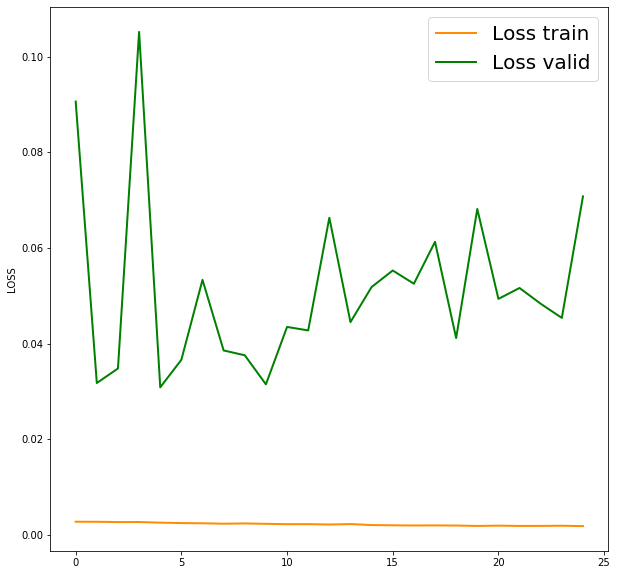

In [458]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2


plt.figure(figsize = (10, 10))
plt.plot(res_model_fin_15.index, res_model_fin_15['loss'], color='darkorange',
         lw=lw, label='Loss train')
plt.plot(res_model_fin_15.index, res_model_fin_15['val_loss'], color='green',
         lw=lw, label='Loss valid')


#plt.ylim(0, 1)
plt.ylabel('LOSS')
plt.legend(loc="best", fontsize = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

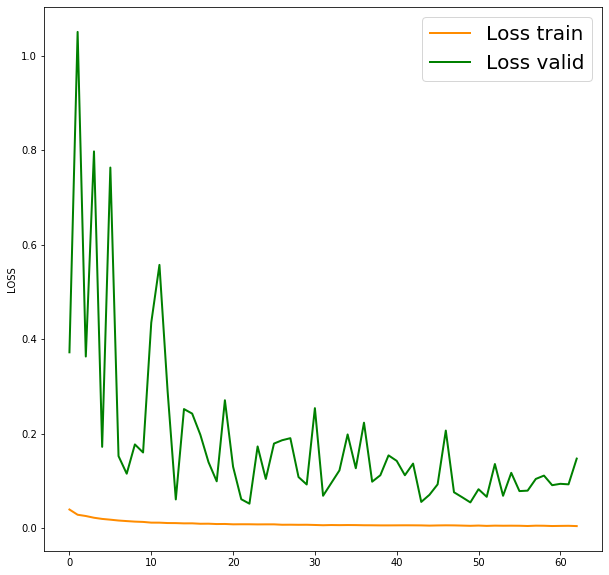

In [423]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2


plt.figure(figsize = (10, 10))
plt.plot(res_model_6.index, res_model_6['loss'], color='darkorange',
         lw=lw, label='Loss train')
plt.plot(res_model_6.index, res_model_6['val_loss'], color='green',
         lw=lw, label='Loss valid')



plt.ylabel('LOSS')
plt.legend(loc="best", fontsize = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

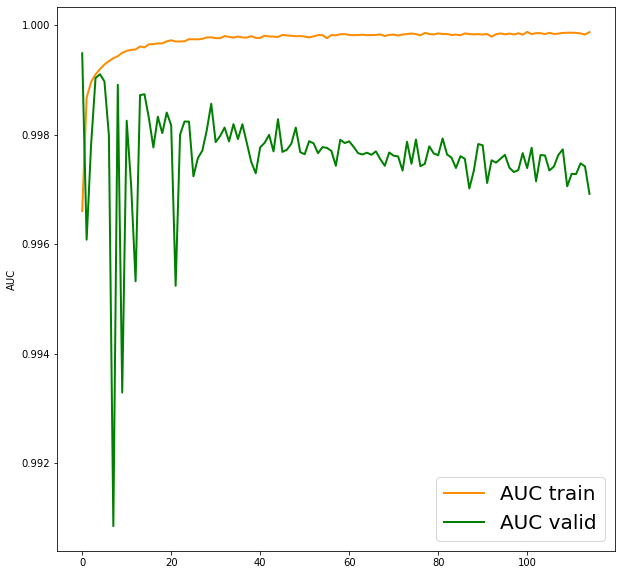

In [420]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2


plt.figure(figsize = (10, 10))
plt.plot(res_model_9.index, res_model_9['auc_8'], color='darkorange',
         lw=lw, label='AUC train')
plt.plot(res_model_9.index, res_model_9['val_auc_8'], color='green',
         lw=lw, label='AUC valid')



plt.ylabel('AUC')
plt.legend(loc="best", fontsize = 20)
plt.show()

In [62]:
with tf.device('/device:GPU:2'):
    history_X = model.fit(X_1_2, Y_train_2,
                                        batch_size=BATCH_SIZE,
                                        epochs=NB_EPOCH,
                                        verbose=VERBOSE,
                                        #validation_split=VALIDATION_SPLIT,
                          validation_data = (X_2_2, Y_test_2), 
                                        class_weight=class_weighting,
                                        callbacks=[_time, EarlyStopping(monitor='val_loss', patience=40)])

train_begin | time:  01.09.2020 13:42:15
Epoch 1/100
epoch_end | time:  01.09.2020 13:49:10
5655/5655 - 412s - loss: 0.0014 - accuracy: 0.8118 - auc: 0.8808 - precision: 0.8118 - recall: 0.8118 - val_loss: 0.5702 - val_accuracy: 0.7160 - val_auc: 0.8067 - val_precision: 0.7160 - val_recall: 0.7160
Epoch 2/100
epoch_end | time:  01.09.2020 13:55:07
5655/5655 - 357s - loss: 9.9712e-04 - accuracy: 0.8543 - auc: 0.9358 - precision: 0.8543 - recall: 0.8543 - val_loss: 0.1418 - val_accuracy: 0.9448 - val_auc: 0.9891 - val_precision: 0.9448 - val_recall: 0.9448
Epoch 3/100
epoch_end | time:  01.09.2020 14:01:56
5655/5655 - 409s - loss: 8.8400e-04 - accuracy: 0.8688 - auc: 0.9488 - precision: 0.8688 - recall: 0.8688 - val_loss: 0.3639 - val_accuracy: 0.8405 - val_auc: 0.9271 - val_precision: 0.8405 - val_recall: 0.8405
Epoch 4/100
epoch_end | time:  01.09.2020 14:08:02
5655/5655 - 366s - loss: 8.0387e-04 - accuracy: 0.8805 - auc: 0.9572 - precision: 0.8805 - recall: 0.8805 - val_loss: 0.3450 -

In [65]:
#res_model = pd.DataFrame(history_X.history, columns = history_X.history.keys())
res_model_2 = pd.DataFrame(history_X.history, columns = history_X.history.keys())

In [66]:
model.save('spider_NN_six.h5')

In [71]:
AUC*2-1

0.8102689637219846

In [633]:
2*0.994885 - 1

0.98977

In [67]:
res_model_2.head()

,loss,accuracy,auc,precision,recall,val_loss,val_accuracy,val_auc,val_precision,val_recall
0,0.001382,0.811846,0.880822,0.811846,0.811846,0.570157,0.715968,0.806669,0.715968,0.715968
1,0.000997,0.854292,0.935795,0.854292,0.854292,0.141777,0.944839,0.989076,0.944839,0.944839
2,0.000884,0.868828,0.948778,0.868828,0.868828,0.363947,0.840457,0.927111,0.840457,0.840457
3,0.000804,0.880527,0.957214,0.880527,0.880527,0.345042,0.844621,0.932069,0.844621,0.844621
4,0.000752,0.886883,0.961919,0.886883,0.886883,0.259769,0.890376,0.962675,0.890376,0.890376


<Figure size 432x288 with 0 Axes>

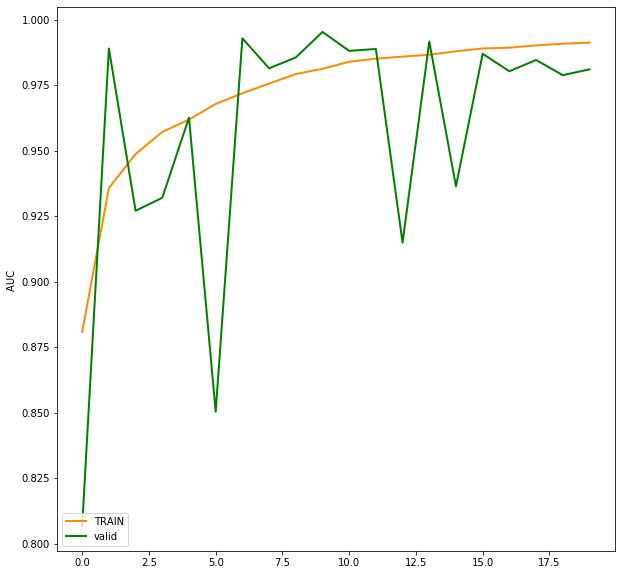

In [69]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2


plt.figure(figsize = (10, 10))
plt.plot(res_model_2.index, res_model_2['auc'], color='darkorange',
         lw=lw, label='TRAIN')
plt.plot(res_model_2.index, res_model_2['val_auc'], color='green',
         lw=lw, label='valid')



plt.ylabel('AUC ')
plt.legend(loc="lower left")
plt.show()

<Figure size 432x288 with 0 Axes>

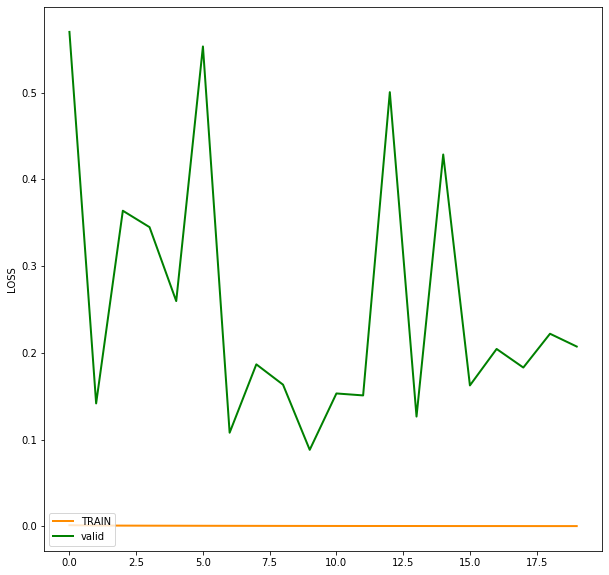

In [70]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2


plt.figure(figsize = (10, 10))
plt.plot(res_model_2.index, res_model_2['loss'], color='darkorange',
         lw=lw, label='TRAIN')
plt.plot(res_model_2.index, res_model_2['val_loss'], color='green',
         lw=lw, label='valid')



plt.ylabel('LOSS')
plt.legend(loc="lower left")
plt.show()

In [80]:
sum(Y_test_2[:,0])

354592.0

In [81]:
sum(Y_test_2[:,1])

604.0

In [83]:
predict_class_train = model.predict(X_1_2)

In [84]:
predict_class_train

array([[9.9996161e-01, 3.8382463e-05],
       [1.0000000e+00, 4.4071404e-09],
       [9.9999869e-01, 1.3394175e-06],
       ...,
       [9.9999809e-01, 1.9658321e-06],
       [3.5410479e-02, 9.6458954e-01],
       [9.9999344e-01, 6.6111629e-06]], dtype=float32)

In [87]:
APS = metrics.average_precision_score(y_train, predict_class_train[:,1])
AUC = metrics.roc_auc_score(y_train, predict_class_train[:,1])

In [88]:
APS, AUC

(0.15623161804592345, 0.9921058914628333)

In [89]:
predict_class_val = model.predict(X_2_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
APS, AUC

In [90]:
APS, AUC

(0.03934633938332663, 0.9263021639533036)

In [91]:
2*AUC-1

0.8526043279066071

In [397]:
def s_l( pool_size, stride):
    """ 
    A single convolutional "layer" as defined by Huang et al. Defined as H_l in the original paper
    
    :param k: кол-во фильтров в свертке
    :param kernel_width: размер свертки
    :param pool_size: размер пулинга
    """

    def f(x): 
        x = MaxPooling1D(
            pool_size=pool_size,
            strides=stride,
            padding="same")(x)

        return x
    return f


def pool_block(k, num_layers, kernel_width, pool_size, stride):
    """
    :param num_layers: кол-во слоев пулинга
    :param kernel_width: размер ядра свертки
    
    :param k: кол-во фильтров в свертке
    :param kernel_width: размер свертки
    """
    def f(x):
        x = Conv1D(
            k,
            kernel_width,
            strides=1,
            padding="same",
            dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        layers_to_concat = [x]
        for _ in range(num_layers):
            x = s_l(pool_size, stride)(x)
            layers_to_concat.append(x)
            x = Concatenate(axis=-1)(layers_to_concat)
        return x
    return f


In [398]:
k = pool_block(3, 5, 3, 2, 1)

In [395]:
k

<function __main__.pool_block.<locals>.f(x)>

In [403]:
k #свертка 2 раза, а не 1!!!

<tf.Tensor: shape=(1, 7, 6), dtype=float32, numpy=
array([[[1.667719  , 0.100654  , 0.9134741 , 2.3894887 , 0.53350765,
         2.2931623 ],
        [2.3894887 , 0.53350765, 2.2931623 , 3.1112587 , 0.9663613 ,
         3.6728508 ],
        [3.1112587 , 0.9663613 , 3.6728508 , 3.8330286 , 1.399215  ,
         5.0525393 ],
        [3.8330286 , 1.399215  , 5.0525393 , 4.554798  , 1.8320686 ,
         6.432227  ],
        [4.554798  , 1.8320686 , 6.432227  , 5.2765684 , 2.264922  ,
         7.811916  ],
        [5.2765684 , 2.264922  , 7.811916  , 5.2765684 , 2.264922  ,
         8.34999   ],
        [0.3692714 , 1.9939451 , 8.34999   , 0.3692714 , 1.9939451 ,
         8.34999   ]]], dtype=float32)>

In [436]:
import tensorflow as tf
x = tf.constant([1., 2., 3., 4., 5., 6., 7])
x = tf.reshape(x, [1, 7, 1])
conv_1d = Conv1D(filters=25, kernel_size=3, padding='same', activation='relu',
                         input_shape=([1, 7, 1]))

conv_1d_5 = Conv1D(filters=5, kernel_size=3, padding='same', activation='relu',
                         input_shape=([1, 7, 25]))
#max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')
k = conv_1d(x)
kk2 = conv_1d_5(k)
#kk = max_pool_1d(k)

In [437]:
kk2

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[0.        , 0.60671216, 0.694368  , 0.        , 0.        ],
        [0.        , 0.71469116, 0.98949367, 0.        , 0.        ],
        [0.        , 0.7249126 , 1.2461513 , 0.        , 0.        ],
        [0.        , 0.78070444, 1.5122572 , 0.        , 0.        ],
        [0.        , 0.8325567 , 1.771276  , 0.        , 0.        ],
        [0.        , 0.        , 0.6524774 , 0.        , 0.28409478],
        [0.        , 0.6246696 , 0.04834281, 0.        , 1.1027939 ]]],
      dtype=float32)>

In [413]:
k

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.12775722, 1.3829485 ],
        [0.43955427, 0.        , 0.        , 0.3751788 , 2.5296407 ],
        [0.89064807, 0.        , 0.        , 0.7073235 , 3.9164488 ],
        [1.3417419 , 0.        , 0.        , 1.0394682 , 5.3032575 ],
        [1.7928356 , 0.        , 0.        , 1.3716128 , 6.6900654 ],
        [3.9878983 , 0.        , 0.        , 2.5080829 , 6.4465575 ],
        [3.9132476 , 0.        , 0.        , 0.7996154 , 6.130576  ]]],
      dtype=float32)>

In [414]:
import tensorflow as tf
x = tf.constant([1., 2., 3., 4., 5., 6., 7])
x = tf.reshape(x, [1, 7, 1])
max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')
kk = max_pool_1d(x)

In [415]:
kk

<tf.Tensor: shape=(1, 7, 1), dtype=float32, numpy=
array([[[2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [7.]]], dtype=float32)>

In [416]:
Concatenate(axis=-1)([kk, k])

<tf.Tensor: shape=(1, 7, 6), dtype=float32, numpy=
array([[[2.        , 0.        , 0.        , 0.        , 0.12775722,
         1.3829485 ],
        [3.        , 0.43955427, 0.        , 0.        , 0.3751788 ,
         2.5296407 ],
        [4.        , 0.89064807, 0.        , 0.        , 0.7073235 ,
         3.9164488 ],
        [5.        , 1.3417419 , 0.        , 0.        , 1.0394682 ,
         5.3032575 ],
        [6.        , 1.7928356 , 0.        , 0.        , 1.3716128 ,
         6.6900654 ],
        [7.        , 3.9878983 , 0.        , 0.        , 2.5080829 ,
         6.4465575 ],
        [7.        , 3.9132476 , 0.        , 0.        , 0.7996154 ,
         6.130576  ]]], dtype=float32)>

In [544]:
from keras.layers import ReLU

In [410]:
time_steps, n_features

(10000, 50)